# Model for predicting muscle activity based on PPN data
## Prepare and organize
### Import libraries

In [2]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import scipy as sp 
import scipy.io as sio
import matplotlib.pyplot as plt
if int(os.environ.get("MODERN_PANDAS_EPUB", 0)):
    import prep # noqa == No Quality Assurance

import sklearn
from sklearn.cluster import KMeans
import random
# ML
from sklearn.linear_model import LinearRegression 
reg=LinearRegression()
from sklearn.cross_validation import train_test_split

from timeit import default_timer as timer

pd.options.display.max_rows = 46

C:\Users\leopt\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Load the data

In [3]:
os.chdir('C:\\datAn\\mena\\data_mat')
file_names = os.listdir()
file_names_3ch = []
file_names_4ch = []
for i in file_names:
    if i[-4:]=='.mat':
        k = sio.whosmat(i)
        if k[0][1][1] == 3:
            file_names_3ch.append(i)
        elif k[0][1][1] == 4:
            file_names_4ch.append(i)

### Create data structures

In [4]:
trials = [];
for i in file_names_3ch:
    trials.append(sio.loadmat(i))
spk_ts = []; emgs = []; musc = [];


# extract 3 channels
for i in trials:
    spk = i['data'][0][1][1][0][0][0]
    #emg = i['data'][0][0][1][0][0][1]
    mus = i['data'][0][2][1][0][0][1]
    spk = [int(s) for s in spk]
    #emg = [float(e) for e in emg]
    mus = [float(m) for m in mus]
    spk_ts.append(spk)
    #emgs.append(emg)
    musc.append(mus)
    

In [6]:
# Create a pandas data frame
#trials = pd.DataFrame({ 'spike times':spk_ts, 'EMGs':emgs, 'movement':musc})
trials = pd.DataFrame({ 'spike times':spk_ts, 'movement':musc})
len(trials['movement'])

46

### Add info on duration and mice number

In [5]:
trials['duration'] = [len(i)/4000 for i in trials['movement'] ]
trials['mice number'] = [i[0:2] for i in file_names_3ch]

### Info for each trial: visual inspection

In [113]:
trials['type'] = ['-']*46; trials['freq'] = ['-']*46
n=0;  trials.loc[n,'type']='mb good'; trials.loc[n,'freq']='high'; trials.loc[n,'burst']='short+long';
n=1;  trials.loc[n,'type']='---'; trials.loc[n,'freq']='low'; trials.loc[n,'burst']='long';
n=2;  trials.loc[n,'type']='---'; trials.loc[n,'freq']='high'; trials.loc[n,'burst']='short+long';
n=3;  trials.loc[n,'type']='mb anti'; trials.loc[n,'freq']='high'; trials.loc[n,'burst']='short';
n=4;  trials.loc[n,'type']='---'; trials.loc[n,'freq']='low'; trials.loc[n,'burst']='---';
n=5;  trials.loc[n,'type']='---'; trials.loc[n,'freq']='high'; trials.loc[n,'burst']='long';
n=6;  trials.loc[n,'type']='---'; trials.loc[n,'freq']='mid'; trials.loc[n,'burst']='long';
n=7;  trials.loc[n,'type']='---'; trials.loc[n,'freq']='low'; trials.loc[n,'burst']='---';
n=8;  trials.loc[n,'type']='mb anti'; trials.loc[n,'freq']='low'; trials.loc[n,'burst']='short';
n=9;  trials.loc[n,'type']='mb good'; trials.loc[n,'freq']='high'; trials.loc[n,'burst']='long';
n=10; trials.loc[n,'type']='mb good'; trials.loc[n,'freq']='low'; trials.loc[n,'burst']='short';
n=11; trials.loc[n,'type']='---'; trials.loc[n,'freq']='low'; trials.loc[n,'burst']='short';
n=12; trials.loc[n,'type']='mb anti'; trials.loc[n,'freq']='low'; trials.loc[n,'burst']='short';
n=13; trials.loc[n,'type']='---'; trials.loc[n,'freq']='high'; trials.loc[n,'burst']='long';
n=14; trials.loc[n,'type']='---'; trials.loc[n,'freq']='low'; trials.loc[n,'burst']='short';
n=15; trials.loc[n,'type']='---'; trials.loc[n,'freq']='high'; trials.loc[n,'burst']='long';
n=16; trials.loc[n,'type']='---'; trials.loc[n,'freq']='low'; trials.loc[n,'burst']='short';
n=17; trials.loc[n,'type']='mb good'; trials.loc[n,'freq']='low'; trials.loc[n,'burst']='short'; 
n=18; trials.loc[n,'type']='mb good'; trials.loc[n,'freq']='high'; trials.loc[n,'burst']='short';
n=19; trials.loc[n,'type']='GOOD'; trials.loc[n,'freq']='high'; trials.loc[n,'burst']='short';
n=20; trials.loc[n,'type']='GOOD'; trials.loc[n,'freq']='high'; trials.loc[n,'burst']='short';
n=21; trials.loc[n,'type']='mb good'; trials.loc[n,'freq']='high'; trials.loc[n,'burst']='---';
n=22; trials.loc[n,'type']='---'; trials.loc[n,'freq']='high'; trials.loc[n,'burst']='---';
n=23; trials.loc[n,'type']='mb good'; trials.loc[n,'freq']='low'; trials.loc[n,'burst']='short'; 
n=24; trials.loc[n,'type']='GOOD'; trials.loc[n,'freq']='low'; trials.loc[n,'burst']='short'; 
n=25; trials.loc[n,'type']='GOOD'; trials.loc[n,'freq']='mid'; trials.loc[n,'burst']='short';
n=26; trials.loc[n,'type']='GOOD'; trials.loc[n,'freq']='mid'; trials.loc[n,'burst']='short';
n=27; trials.loc[n,'type']='GOOD'; trials.loc[n,'freq']='low'; trials.loc[n,'burst']='short+long';
n=28; trials.loc[n,'type']='GOOD'; trials.loc[n,'freq']='low'; trials.loc[n,'burst']='short';
n=29; trials.loc[n,'type']='ANTI'; trials.loc[n,'freq']='low'; trials.loc[n,'burst']='---';
n=30; trials.loc[n,'type']='GOOD'; trials.loc[n,'freq']='high'; trials.loc[n,'burst']='short+long';
n=31; trials.loc[n,'type']='ANTI'; trials.loc[n,'freq']='high'; trials.loc[n,'burst']='short+long';
n=32; trials.loc[n,'type']='ANTI'; trials.loc[n,'freq']='low'; trials.loc[n,'burst']='---';
n=33; trials.loc[n,'type']='ANTI'; trials.loc[n,'freq']='low'; trials.loc[n,'burst']='---';
n=34; trials.loc[n,'type']='---'; trials.loc[n,'freq']='low'; trials.loc[n,'burst']='short';
n=35; trials.loc[n,'type']='---'; trials.loc[n,'freq']='mid'; trials.loc[n,'burst']='mid';
n=36; trials.loc[n,'type']='---'; trials.loc[n,'freq']='low'; trials.loc[n,'burst']='short';
n=37; trials.loc[n,'type']='---'; trials.loc[n,'freq']='low'; trials.loc[n,'burst']='long';
n=38; trials.loc[n,'type']='GOOD'; trials.loc[n,'freq']='high'; trials.loc[n,'burst']='short+long';
n=39; trials.loc[n,'type']='---'; trials.loc[n,'freq']='high'; trials.loc[n,'burst']='short+long';
n=40; trials.loc[n,'type']='---'; trials.loc[n,'freq']='high'; trials.loc[n,'burst']='---';
n=41; trials.loc[n,'type']='GOOD'; trials.loc[n,'freq']='high'; trials.loc[n,'burst']='short+long';
n=42; trials.loc[n,'type']='---'; trials.loc[n,'freq']='high'; trials.loc[n,'burst']='short+long';
n=43; trials.loc[n,'type']='---'; trials.loc[n,'freq']='high,then low'; trials.loc[n,'burst']='short+long';
n=44; trials.loc[n,'type']='GOOD-ANTI?'; trials.loc[n,'freq']='high,then low'; trials.loc[n,'burst']='short+long';
n=45; trials.loc[n,'type']='---'; trials.loc[n,'freq']='mid'; trials.loc[n,'burst']='---';

k=trials.loc[trials['type']=='GOOD']
k.loc[:,['duration','type','burst','freq','mice number']].sort_values(by=['freq'])


duration  type       burst  freq mice number
19   209.86650  GOOD       short  high          03
20   240.72300  GOOD       short  high          03
30   539.28850  GOOD  short+long  high          04
38   120.61350  GOOD  short+long  high          07
41   707.16175  GOOD  short+long  high          24
24   191.67350  GOOD       short   low          03
27  2764.40750  GOOD  short+long   low          04
28  3217.23925  GOOD       short   low          04
25  2100.56650  GOOD       short   mid          03
26   190.67325  GOOD       short   mid          03

In [299]:
trials.loc[:,['duration','type','burst','fano, 1s','freq', 'freqs', 'mice number']].sort_values(by=['fano, 1s'])

duration        type       burst   fano, 1s           freq      freqs  \
3     96.27000     mb anti       short   0.989529           high   2.306014   
5    125.58375         ---        long   0.991989           high   2.898464   
8    146.78650     mb anti       short   0.993151            low   0.333818   
12   424.77975     mb anti       short   0.997643            low   0.063562   
14   146.83950         ---       short   0.997717            low   0.619724   
11    96.75650         ---       short   0.998264            low   0.568437   
32   609.52825        ANTI         ---   0.998358            low   0.794057   
37   663.46400         ---        long   0.998492            low   0.360231   
33   988.91725        ANTI         ---   0.998989            low   0.940422   
34  1107.75500         ---       short   0.999097            low   0.737528   
0    216.67275     mb good  short+long   0.999228           high   3.969119   
44  1461.33900  GOOD-ANTI?  short+long   0.999316  high,then low   1.962584   
27  2764.40750        GOOD  short+long   0.999639            low   0.727461   
28  3217.23925        GOOD       short   0.999689            low   1.019818   
31   576.26325        ANTI  short+long   0.999711           high   1.924468   
4     85.58475         ---         ---   1.271962            low   1.460541   
16   994.25750         ---       short   1.498659            low   0.135780   
15   120.11050         ---        long   1.658287           high   1.432015   
10   120.88700     mb good       short   1.662506            low   0.777586   
29   213.16125        ANTI         ---   1.743725            low   0.989861   
19   209.86650        GOOD       short   1.792032           high   2.325288   
17   379.34050     mb good       short   1.795601            low   0.205620   
7     68.91975         ---         ---   1.882130            low   0.710972   
42   222.11875         ---  short+long   1.900814           high   2.687751   
45   203.24725         ---         ---   1.995062            mid   2.376416   
36   462.27100         ---       short   1.995669            low   0.190365   
1    188.64875         ---        long   1.996454            low   1.038968   
38   120.61350        GOOD  short+long   1.997218           high   2.918413   
39   160.88425         ---  short+long   1.997919           high   5.488418   
43   798.06125         ---  short+long   2.197911  high,then low   4.936964   
30   539.28850        GOOD  short+long   2.329622           high   3.220911   
2     93.83450         ---  short+long   2.582079           high   3.591430   
18   221.87650     mb good       short   2.703736           high   0.495771   
20   240.72300        GOOD       short   2.856250           high   3.348247   
24   191.67350        GOOD       short   3.111038            low   0.396508   
26   190.67325        GOOD       short   3.992982            mid   1.625818   
22   168.11750         ---         ---   3.996016           high   6.067185   
25  2100.56650        GOOD       short   3.999683            mid   2.840662   
6    162.41825         ---        long   4.989691            mid   1.797828   
23   397.58225     mb good       short   5.103554            low   0.729409   
21   193.87375     mb good         ---   5.156313           high   6.952978   
13   306.10050         ---        long   5.996727           high   3.694865   
35   511.61650         ---         mid   6.534223            mid   1.141480   
9    266.09075     mb good        long   6.995606           high   6.561671   
40   233.69200         ---         ---   7.994278           high  11.301200   
41   707.16175        GOOD  short+long  18.995521           high   5.669141   

   mice number  
3           01  
5           01  
8           02  
12          02  
14          02  
11          02  
32          04  
37          06  
33          04  
34          05  
0           01  
44          25  
27          04  
28          04  
31          04  
4           01  
16 

In [9]:
trials['spike bin'] = [ np.zeros(len(trials['EMGs'][i])) for i in range(len(trials)) ]
for i in range(len(trials)):
    trials['spike bin'][i][trials['spike times'][i]] = 1;

### Spike timing data to spike count data conversion

In [240]:
start = timer()
time=200; # in ms
trials['spk count ' + str(time)+'ms']=[[]]*46
period=time*4

for tr_n in range(46):
    spk_coun=[]
    spk_ts = trials['spike times'][tr_n]
    for i in range(len(trials['movement'][tr_n])-period):
        spk=0
        if spk_ts!=[]:
            if spk_ts[0]<i:
                spk_ts=spk_ts[1:]
                
        for j in spk_ts:
            if j < i+period:
                spk=spk+1
            else:
                break
        spk_coun.append(spk)
    trials['spk count ' + str(time)+'ms'][tr_n]=spk_coun
    # movement
    #move_mean.append(np.mean(moves[i:i+period]))
    
end = timer()
print(end - start)

9.036092850990826
11045639


# Correlations: frequency within window and mean activity in the window

[[], [], [], []]

In [30]:
start = timer()
time=200;
trials['spk count ' + str(time)+'ms']=[[]]*46
period=time*4

for tr_n in range(46):
    spk_coun=[]
    spk_ts = trials['spike times'][tr_n]
    for i in range(len(trials['movement'][tr_n])-period):
        spk=0
        if spk_ts!=[]:
            if spk_ts[0]<i:
                spk_ts=spk_ts[1:]
                
        for j in spk_ts:
            if j < i+period:
                spk=spk+1
            else:
                break
        spk_coun.append(spk)
    trials['spk count ' + str(time)+'ms'][tr_n]=spk_coun
    # movement
    #move_mean.append(np.mean(moves[i:i+period]))
    
end = timer()
print(end - start)

41.99152630002936


In [ ]:
### Compute movement mean 

In [34]:
start = timer()
time=200;
trials[['movement mean ' + str(time) + 'ms']]=[[]]*46
period=time*4

for tr_n in range(46):
    move=trials['movement'][tr_n]
    move_mean=[]
    for i in range(len(move)-period):
        move_mean.append(np.mean(move[i:i+period]))
    # movement
    trials[['movement mean ' + str(time) + 'ms']][tr_n]=move_mean

    
end = timer()
print(end - start)

4193.129166874045


# Cross correlation

In [27]:
def crosscorr(xx,yy,lag):
    corrs=[]
    for l in np.arange(0,lag*2,8):
        crc=0
        for i in np.arange(len(xx)-2*lag):
            crc=crc+xx[i+l]*yy[i+lag]
        corrs.append(crc)
    return corrs

tr_n=0


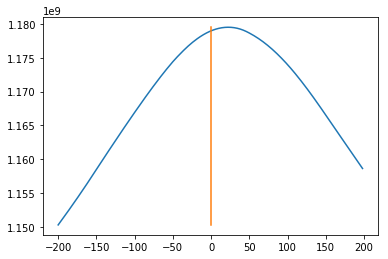

tr_n=1


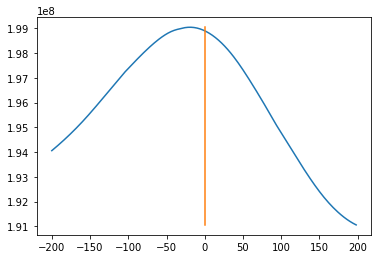

tr_n=2


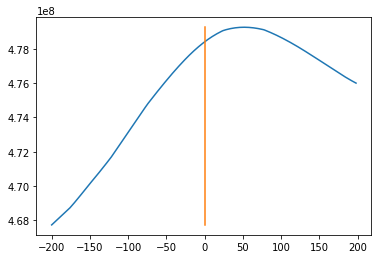

tr_n=3


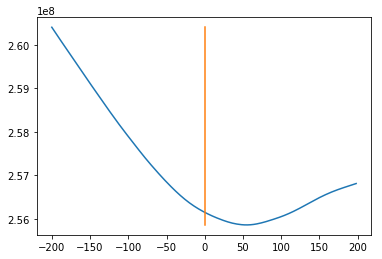

tr_n=4


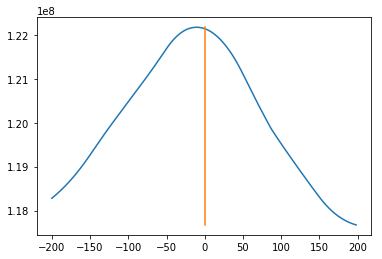

tr_n=5


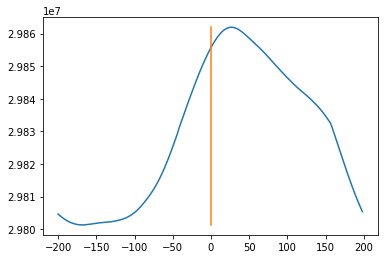

tr_n=6


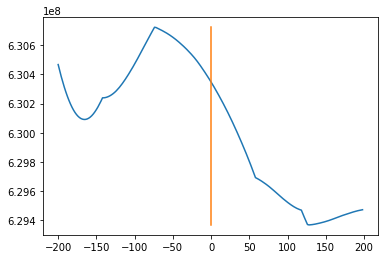

tr_n=7


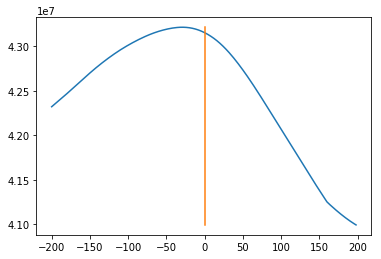

tr_n=8


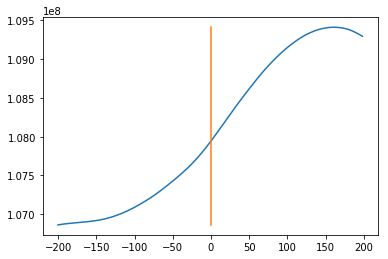

tr_n=9


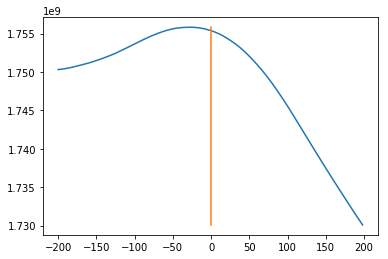

tr_n=10


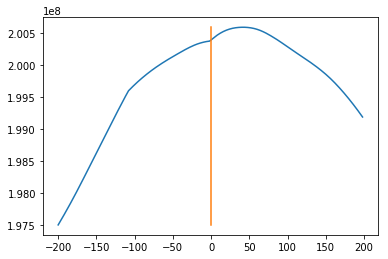

tr_n=11


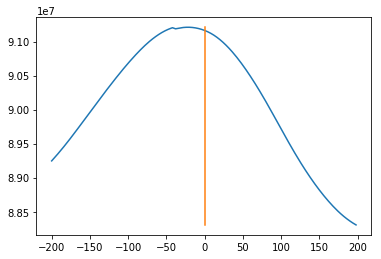

tr_n=12


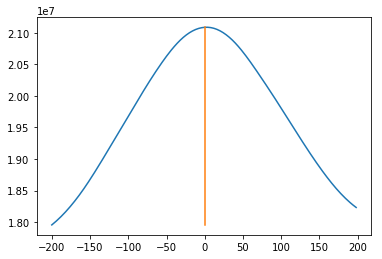

tr_n=13


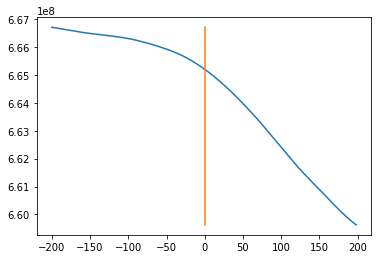

tr_n=14


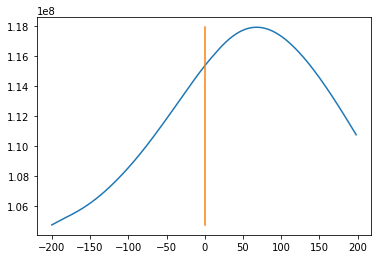

tr_n=15


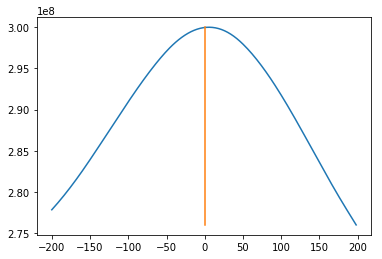

tr_n=16


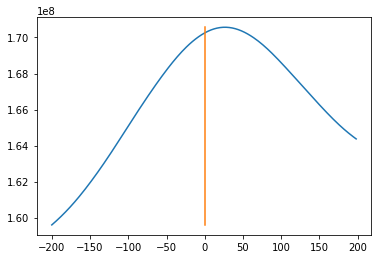

tr_n=17


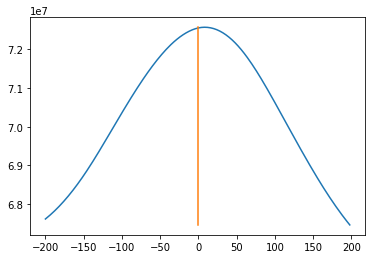

tr_n=18


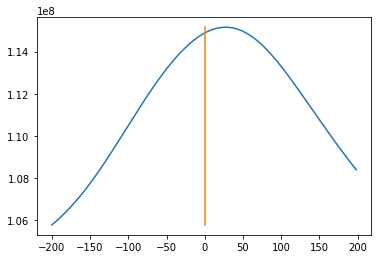

tr_n=19


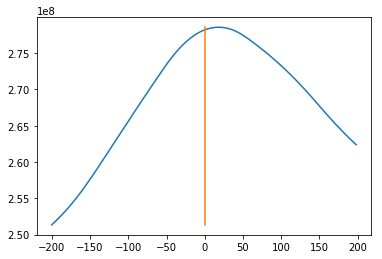

tr_n=20


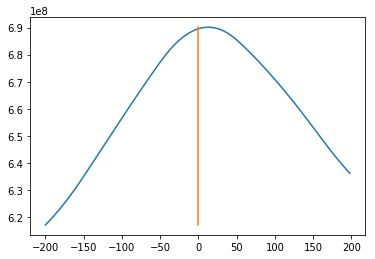

tr_n=21


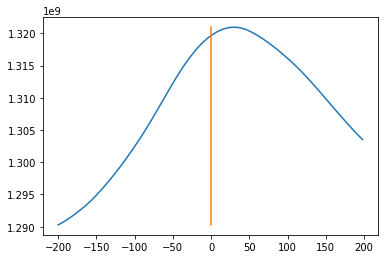

tr_n=22


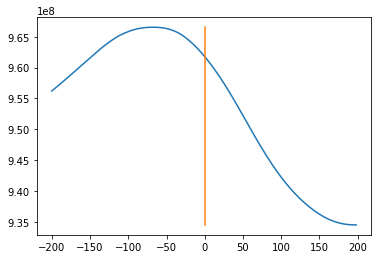

tr_n=23


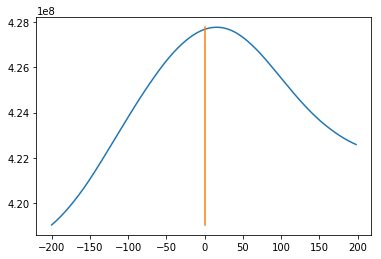

tr_n=24


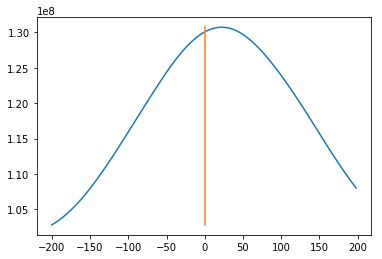

tr_n=25


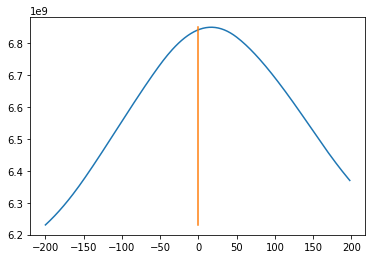

tr_n=26


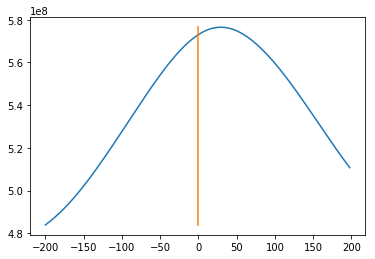

tr_n=27


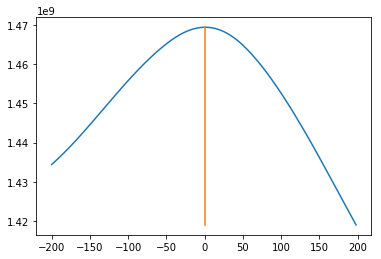

tr_n=28


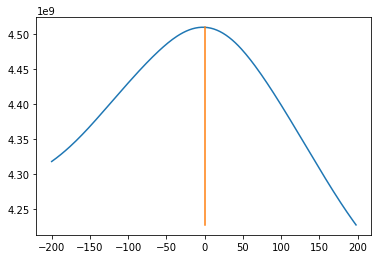

tr_n=29


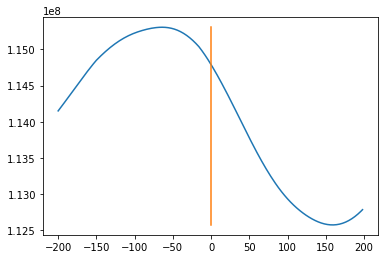

tr_n=30


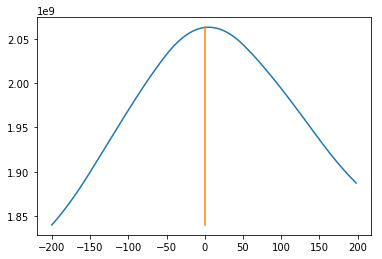

tr_n=31


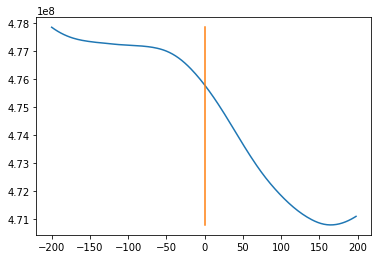

tr_n=32


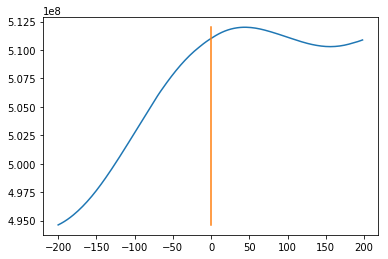

tr_n=33


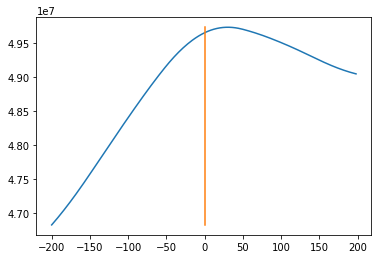

tr_n=34


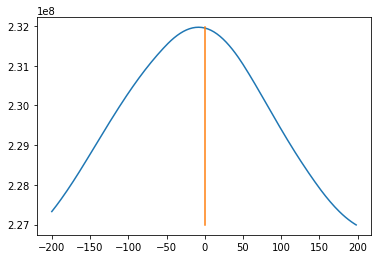

tr_n=35


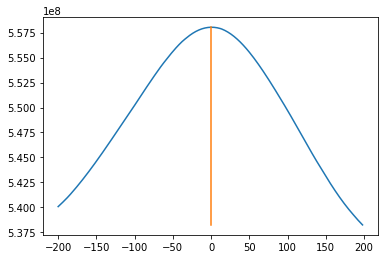

tr_n=36


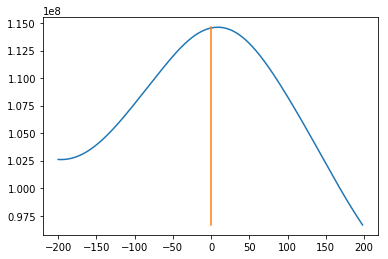

tr_n=37


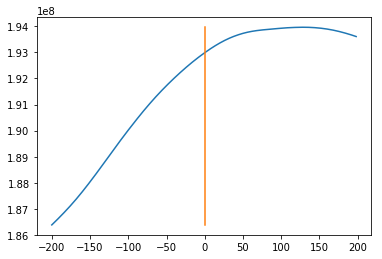

tr_n=38


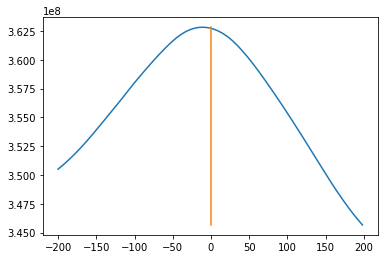

tr_n=39


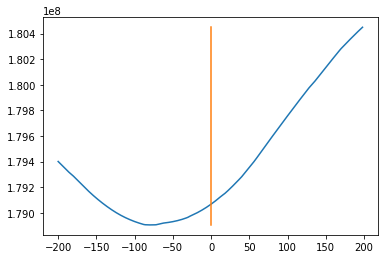

tr_n=40


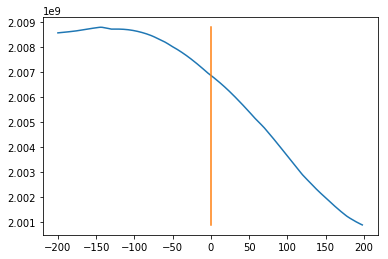

tr_n=41


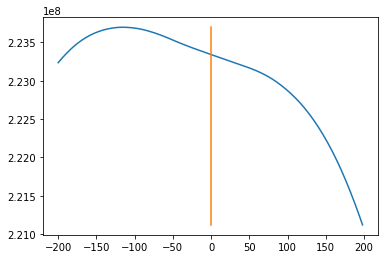

tr_n=42


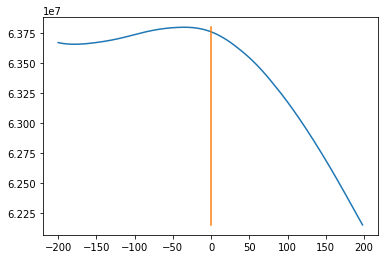

tr_n=43


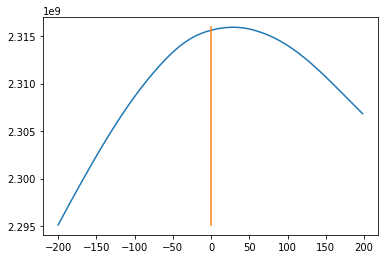

tr_n=44


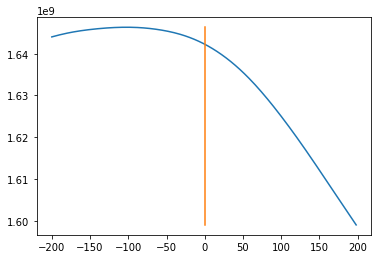

tr_n=45


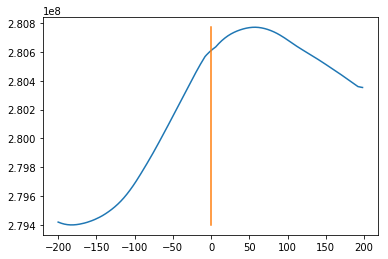

11583.061646634014


In [36]:
trials['crosscorr_m']=[[]]*46

start=timer()
mxlag=800

for tr_n in np.arange(46): 
    XX = trials['spk count 200ms'][tr_n] 
    YY = trials['movement mean 200ms'][tr_n]; 
    crcr=crosscorr(XX,YY,mxlag)
    trials['crosscorr_m'][tr_n]=crcr
    np.save('crosscorr_m'+str(tr_n)+'.npy',trials['crosscorr_m'][tr_n])
    print('tr_n=' + str(tr_n))
    plt.plot(range(-200,200,2),crcr)
    plt.plot([0,0],[min(crcr),max(crcr)])
    plt.show()
end=timer()
print(end-start)

tr_n=0


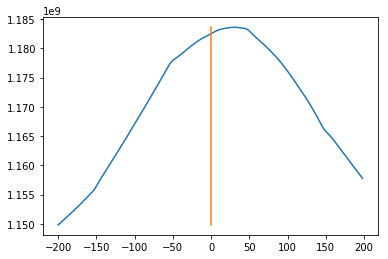

tr_n=1


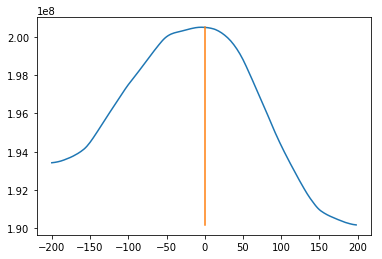

tr_n=2


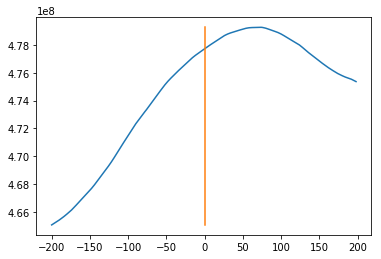

tr_n=3


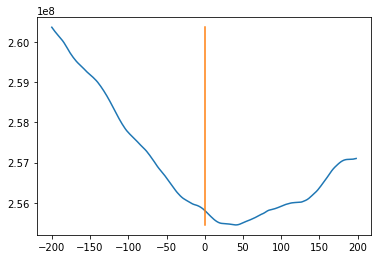

tr_n=4


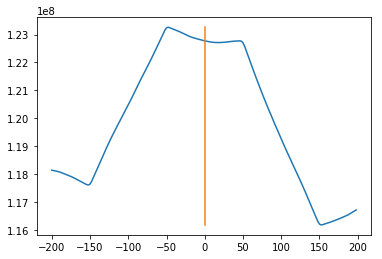

tr_n=5


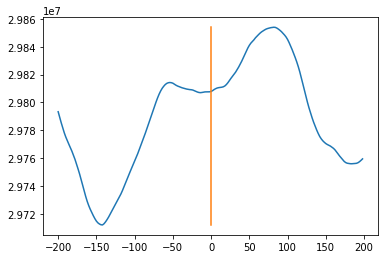

tr_n=6


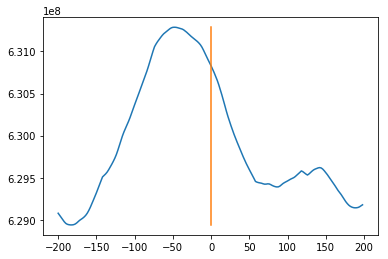

tr_n=7


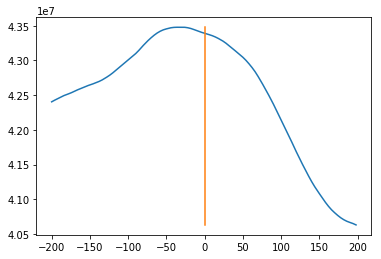

tr_n=8


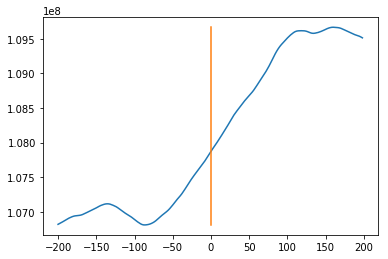

tr_n=9


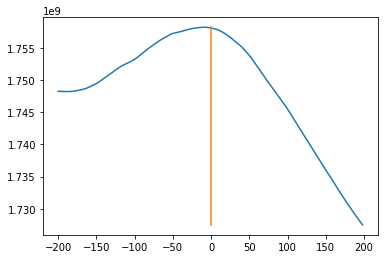

tr_n=10


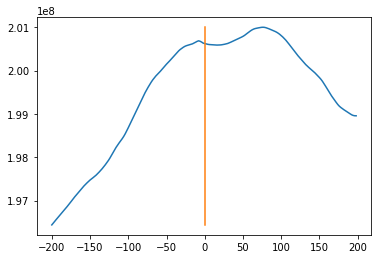

tr_n=11


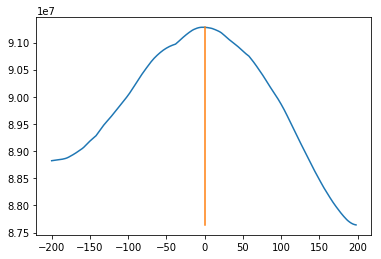

tr_n=12


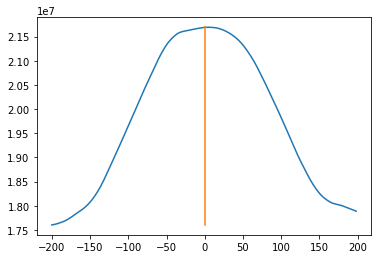

tr_n=13


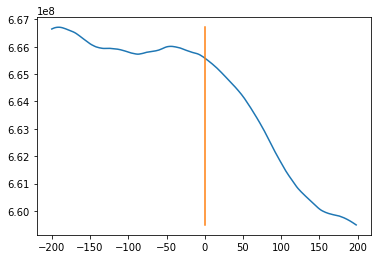

tr_n=14


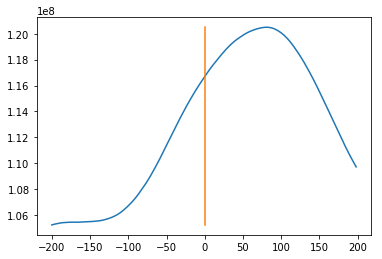

tr_n=15


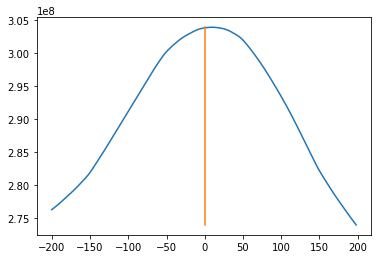

tr_n=16


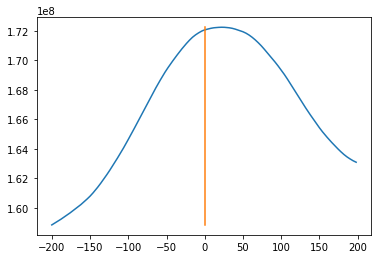

tr_n=17


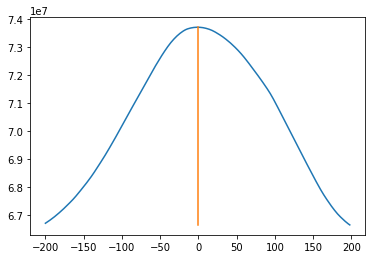

tr_n=18


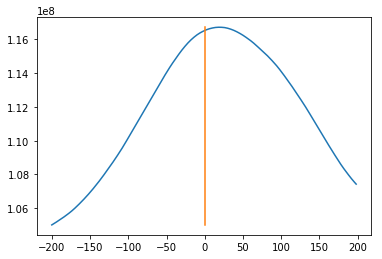

tr_n=19


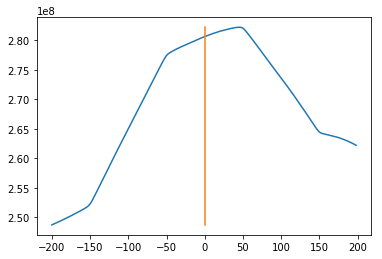

tr_n=20


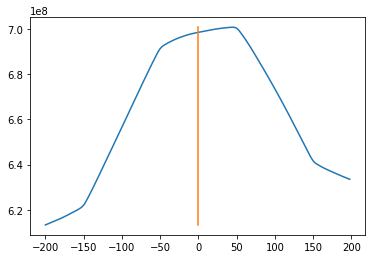

tr_n=21


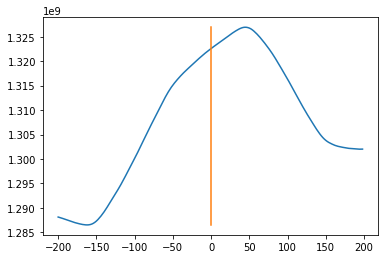

tr_n=22


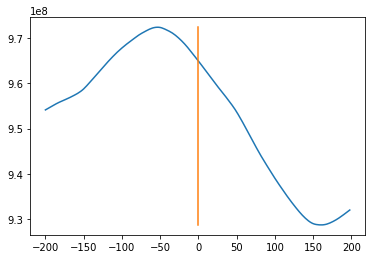

tr_n=23


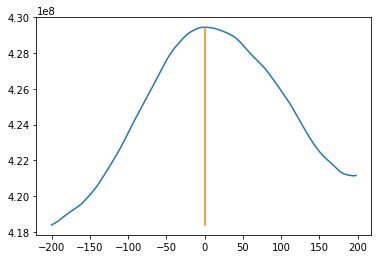

tr_n=24


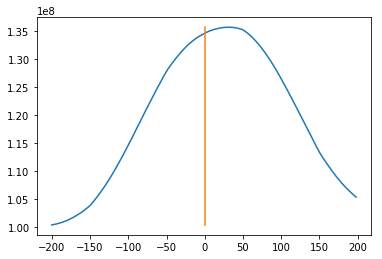

tr_n=25


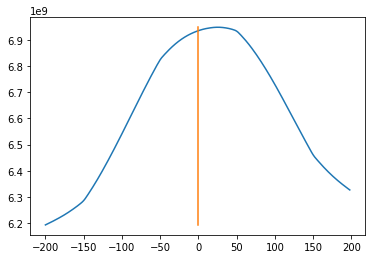

tr_n=26


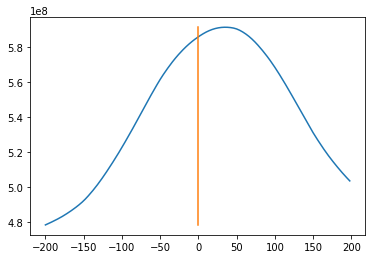

tr_n=27


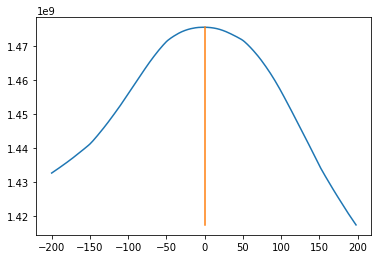

tr_n=28


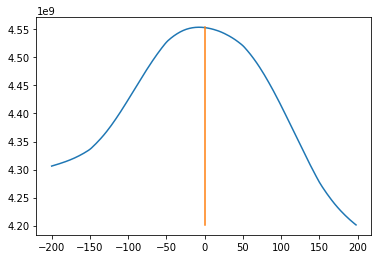

tr_n=29


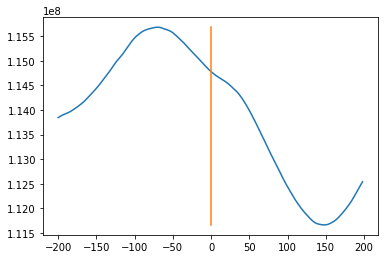

tr_n=30


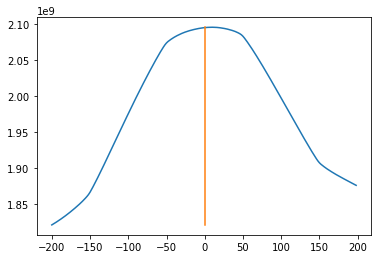

tr_n=31


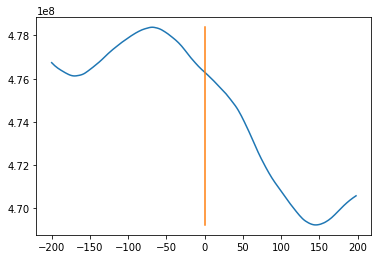

tr_n=32


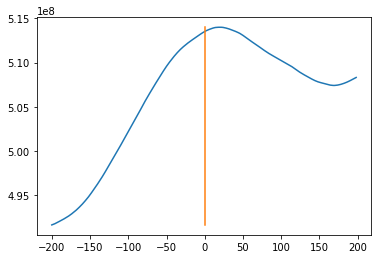

tr_n=33


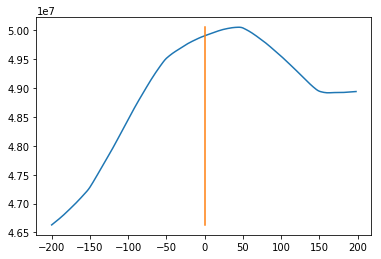

tr_n=34


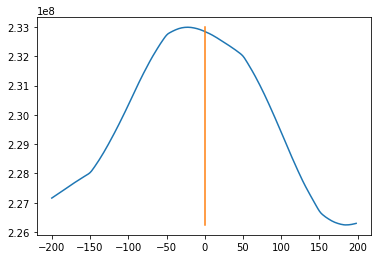

tr_n=35


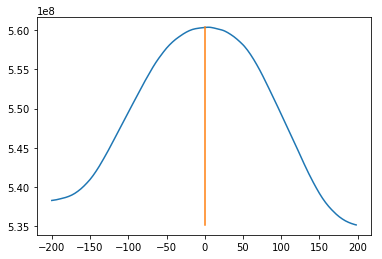

tr_n=36


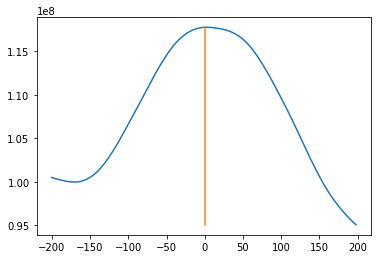

tr_n=37


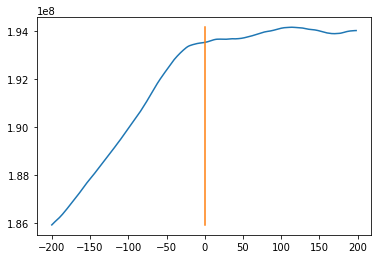

tr_n=38


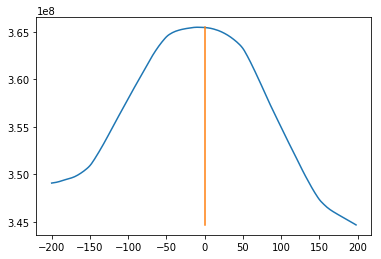

tr_n=39


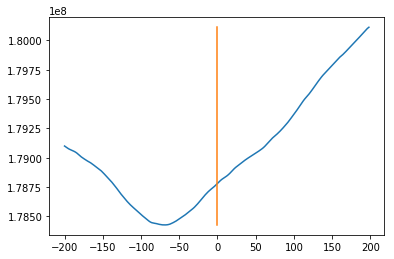

tr_n=40


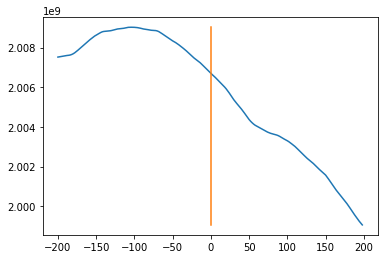

tr_n=41


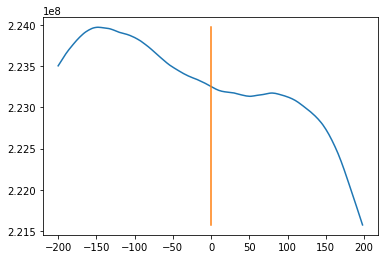

tr_n=42


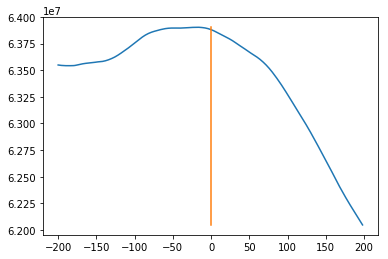

tr_n=43


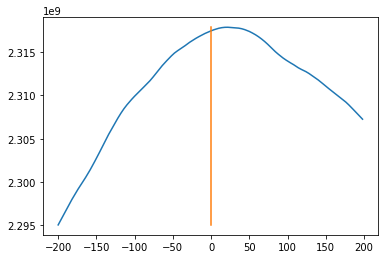

tr_n=44


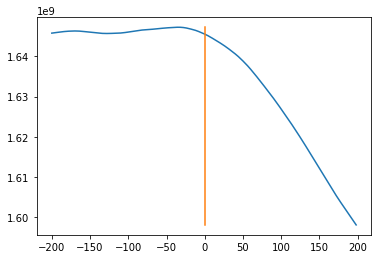

tr_n=45


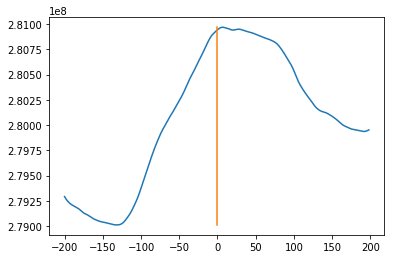

7581.329957185022


In [31]:
start=timer()
mxlag=800

for tr_n in np.arange(46): #[24,27,28,26,44,19,25,38,20,30,41] 
    XX = trials['spk count 200ms'][tr_n] 
    YY = trials['movement'][tr_n]; 
    YY = YY[400:]
    XX = XX[:-400]
    crcr=crosscorr(XX,YY,mxlag)
    trials['crosscorr*'][tr_n]=crcr
    np.save('crosscorr'+str(tr_n)+'.npy',trials['crosscorr*'][tr_n])
    print('tr_n=' + str(tr_n))
    plt.plot(range(-200,200,2),crcr)
    plt.plot([0,0],[min(crcr),max(crcr)])
    plt.show()
end=timer()
print(end-start)

In [ ]:
for tr_n in np.arange(46): #[24,27,28,26,44,19,25,38,20,30,41] 
    crcr=trials['crosscorr*'][tr_n]
    crcr=sp.stats.zscores
    plt.plot(range(-200,200,2),crcr,'b', alpha=.5)
    plt.plot([0,0],[min(crcr),max(crcr)],)
plt.show()

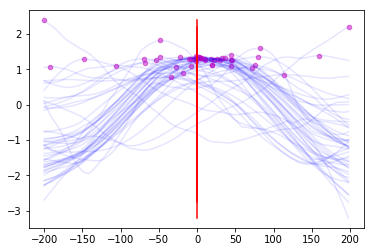

In [49]:
maxs=[]
for tr_n in range(46):
    crcrz = list(sp.stats.zscore(trials['crosscorr*'][tr_n]))
    mxy=max(crcrz), 
    mxx = crcrz.index(mxy)*2-200, 
    maxs.append(mxx)
    plt.plot(range(-200,200,2),crcrz, 'b-', alpha=.1)
    plt.plot(mxx,mxy,'m.', markersize=9, alpha=.5)
    plt.plot([0,0],[min(crcrz),max(crcrz)],'r-')
plt.show()

In [50]:
np.mean(mxx)

6.0

# $ h^2 \ factor $

In [11]:
def h2btwXY(x,y,NbBins):
    x=np.array(x); y=np.array(y)
    bins=np.array(list(np.linspace(min(x),max(x),num=NbBins+1)));
    p = (bins[1:]-bins[:-1])/2 + bins[:-1]
    q = np.zeros(len(p))
    q[0] = np.mean([y[i] for i in range(len(x)) if x[i]<=bins[1]])
    for i in range(1,NbBins-1):
        index = [j for j in range(len(x)) if x[j]>bins[i] and x[j]<=bins[i+1]]
        ii=0;
        while index==[]:
            ii+=1; 
            index = [j for j in range(len(x)) if x[j]>bins[ii+i] and x[j]<=bins[ii+i+1]]
        if ii>0:
            binMed = np.mean(y[index])
            m = (binMed-q[i-1])/(p[ii+i] - p[i-1]); # print('m=' + str(m))
            q[i] = m*(p[i]-p[i-1]) + q[i-1]
        else:
            q[i] = np.mean(y[index])
            
    q[-1] = np.mean(y[x>bins[-2]])
    m = (q[1]-q[0])/(p[1]-p[0])
    xLinFit = np.append(x[x<p[1]], [p[1]])
    linefit = m*(xLinFit-p[0])+q[0]
    yObserved = np.append(y[x<p[1]], q[1])
    error2 = np.zeros(NbBins)
    error2[0] = sum(np.power((yObserved-linefit),2));
    # print('q='+str(q))
    for i in range(1,NbBins-1):
        xBinindex = [j for j in range(len(x)) if x[j]>p[i] and x[j]<p[i+1]]
        m = (q[i+1]-q[i])/(p[i+1]-p[i])
        xLinFit = np.append(p[i], x[xBinindex])
        xLinFit = np.append(xLinFit, p[i+1]); # print('m=' + str(m))
        linefit = m*(xLinFit - p[i]) + q[i]; 
        yObserved = np.append([q[i]], y[xBinindex]); 
        yObserved = np.append(yObserved, q[i+1]); #print('yObserved=' + str(yObserved))
        error2[i] = sum(np.power((yObserved-linefit),2))
    xLinFit = np.append(p[NbBins-1], x[x>p[-1]])
    linefit = m*(xLinFit - p[NbBins-1]) + q[NbBins-1] 
    yObserved = np.append([q[-1]], y[x>p[-1]])
    error2[-1] = sum(np.power((yObserved-linefit),2))
    expVar = sum(np.power((y-np.mean(y)),2))
    h2 = (expVar - sum(error2))/expVar
    return h2

# XX = spk_count; YY = trials['movement'][24]; YY = YY[400:]
# h2btwXY(XX,YY,10)

### Time lag for $h^2$

tr_n=45


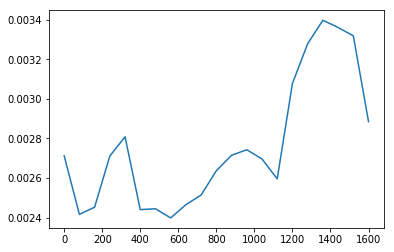

24065.209609456


In [56]:
start=timer()
lags=list(range(0,1601,80))

# movement -> spikes

for tr_n in range(46): 
    h2s=[]
    XX = trials['spk count 200ms'][tr_n] 
    XX = XX[int(lags[-1]/2):]
    for l in lags:
        YY = trials['movement'][tr_n]; 
        start=l; end=len(YY)-(800-l) - int(lags[-1]/2); 
        YY=YY[start:end]
        h2s.append(h2btwXY(YY,XX,10))
    trials['h2yx'][tr_n] = h2s
    h2file = 'h2yx_'+str(tr_n)
    np.save(h2file,h2s)
    print('tr_n='+str(tr_n))
    plt.plot(lags,h2s)
    plt.show()

end=timer()
print(end-start)

Text(0,0.5,'number of occurencies')

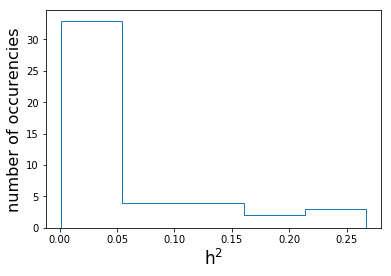

In [230]:
plt.hist(h2s, bins=5, histtype='step')
plt.xlabel('h$^2$',fontsize=17)
plt.ylabel('number of occurencies',fontsize=16)

In [274]:
h2sr=[]
for tr_n in range(46):
    XX = trials['instant frequency'][tr_n] 
    YY = trials['movement'][tr_n]; 
    h2sr.append(h2btwXY(XX,YY,10)) 

In [9]:
trials['h2 inst freq m->s']=[[]]*46

0


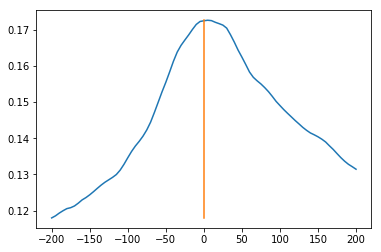

1


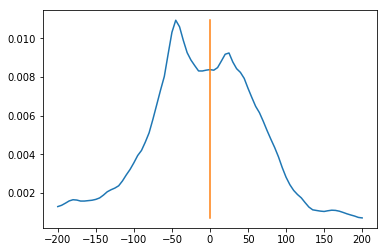

2


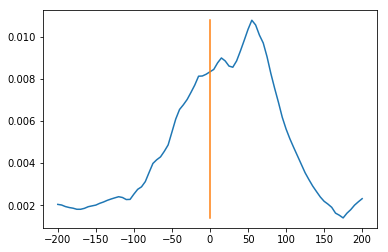

3


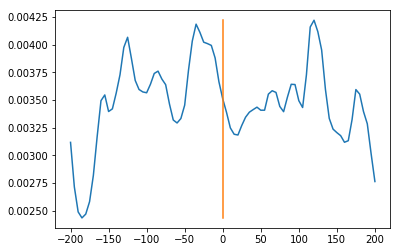

4


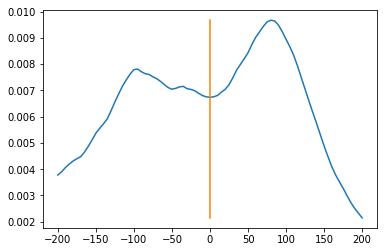

5


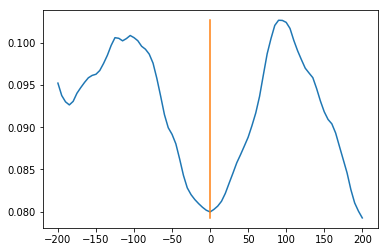

6


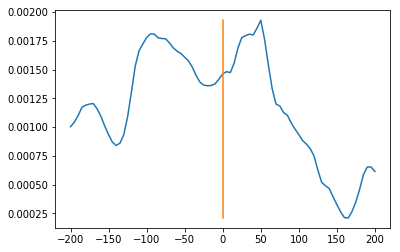

7


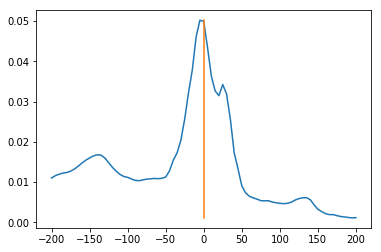

8


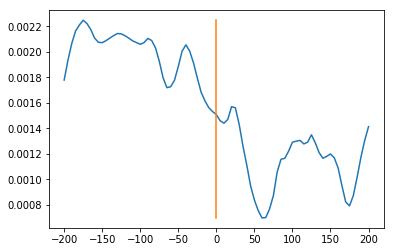

9


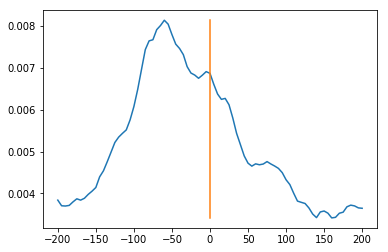

10


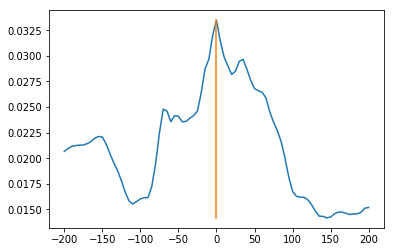

11


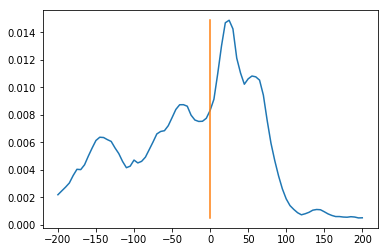

12


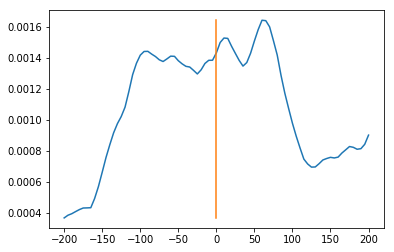

13


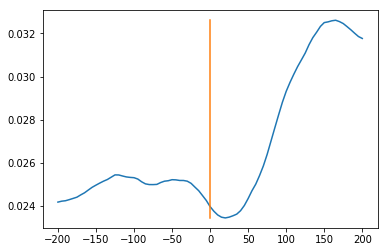

14


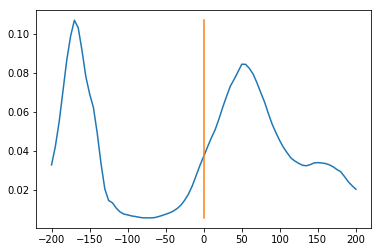

15


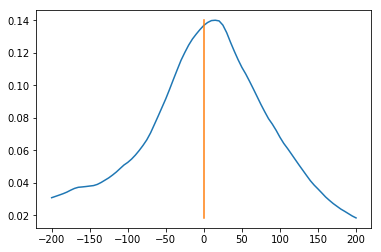

16


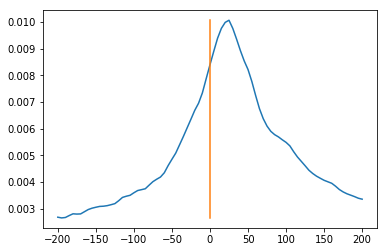

17


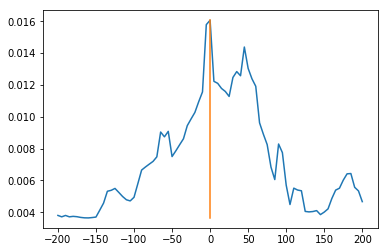

18


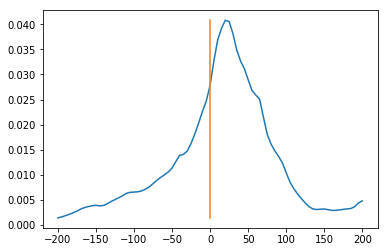

19


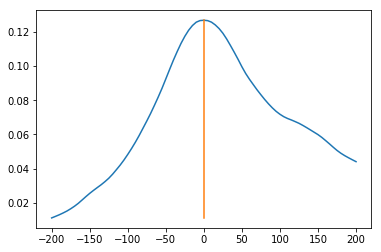

20


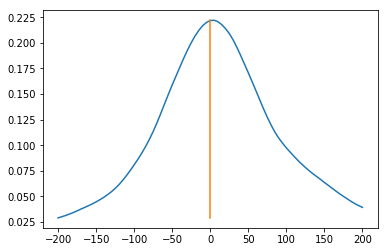

21


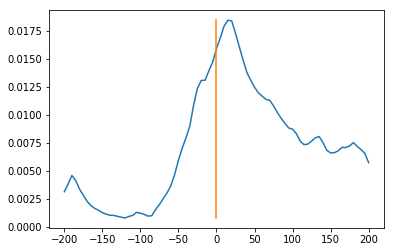

22


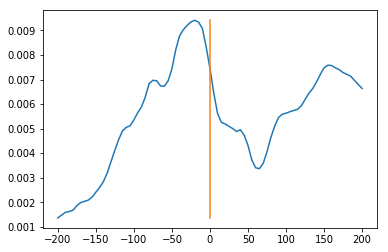

23


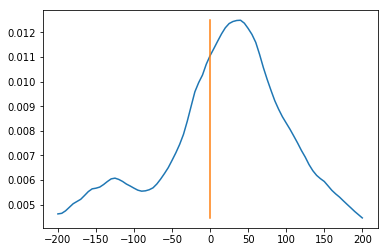

24


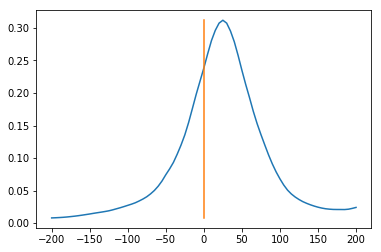

25


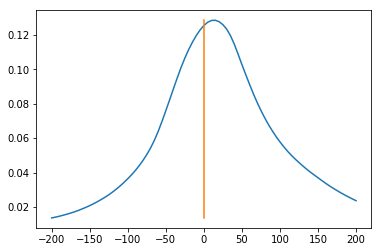

26


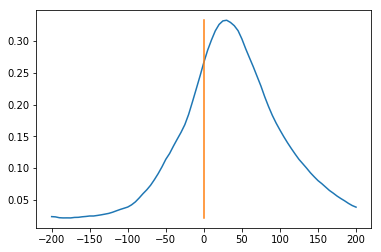

27


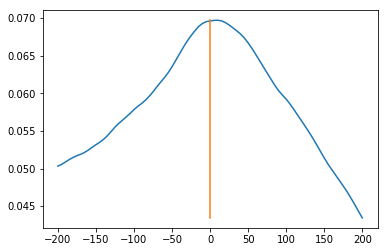

28


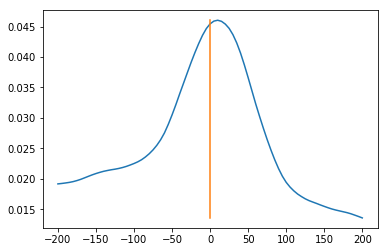

29


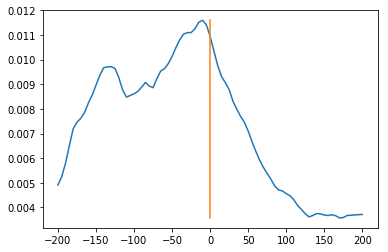

30


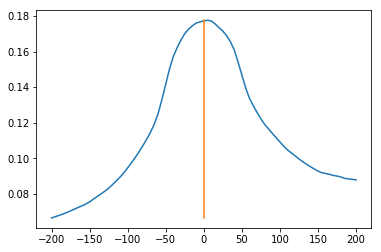

31


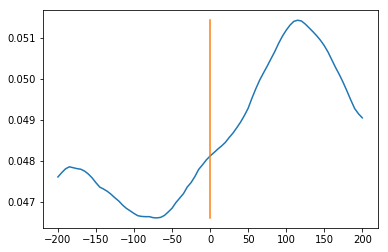

32


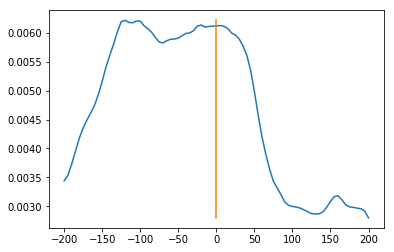

33


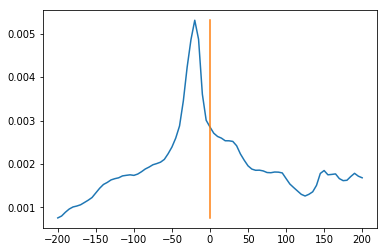

34


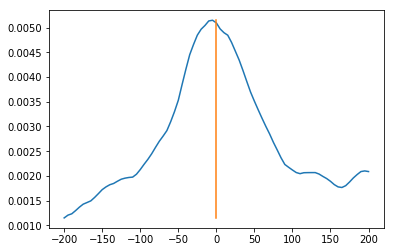

35


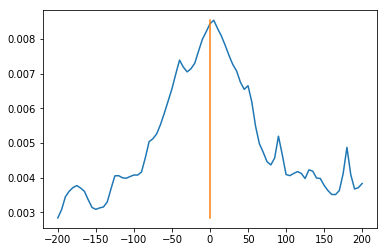

36


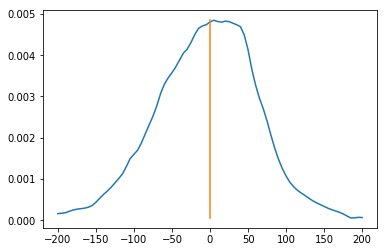

37


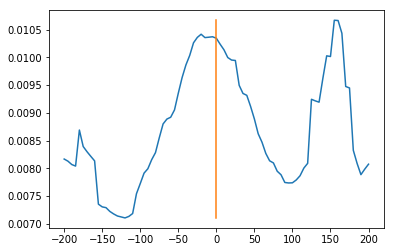

38


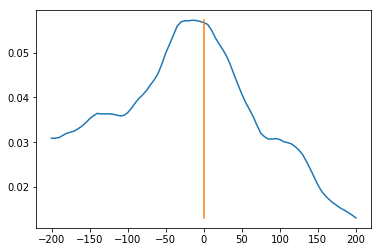

39


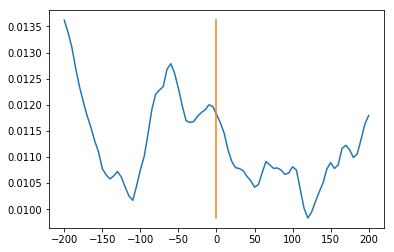

40


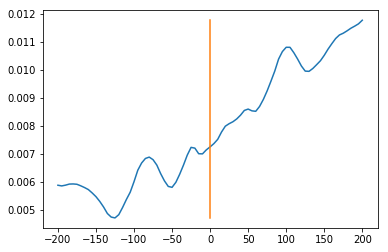

41


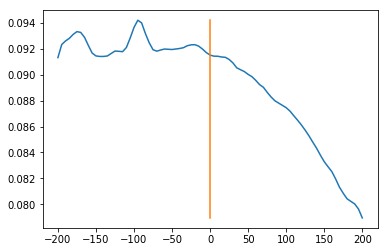

42


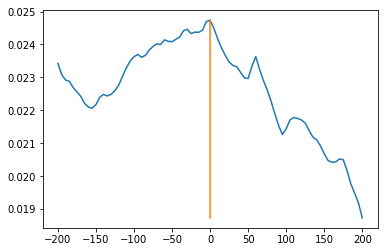

43


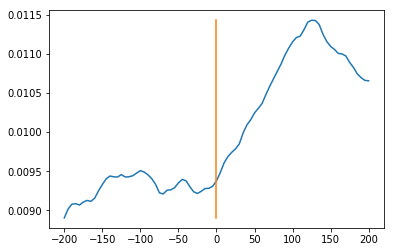

44


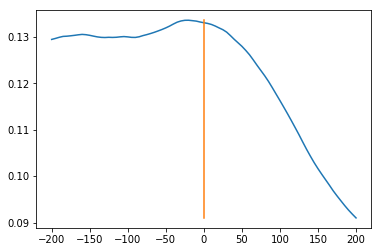

45


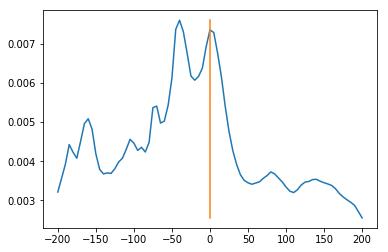

In [21]:
lagmax=800
lags=list(np.arange(0,lagmax*2+1,20)) #1600,20))
for tr_n in range(46):
    h2s=[]
    YY = trials['movement'][tr_n];
    YY = YY[lagmax:-lagmax]
    for l in lags:
        XX = trials['instant frequency'][tr_n]  
        start=l; end=len(XX)-(lagmax*2-l); 
        XX=XX[start:end]
        h2s.append(h2btwXY(YY,XX,10)) 
    trials['h2 inst freq m->s'][tr_n] = h2s
    np.save('h2_inst_freq_ms'+str(tr_n)+'.npy',h2s)
    print(tr_n)
    plt.plot(np.multiply(np.add(lags,-800),.25),h2s)
    plt.plot([0,0], [min(h2s),max(h2s)])
    plt.show()

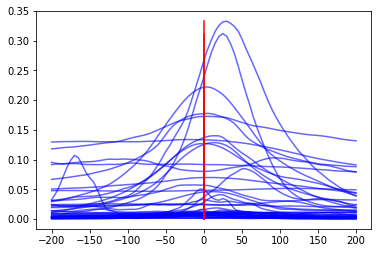

In [26]:
for tr_n in range(46):
    h2s = trials['h2 inst freq m->s'][tr_n]
    plt.plot(np.multiply(np.add(lags,-800),.25),h2s,'b',alpha=.6)
    plt.plot([0,0], [min(h2s),max(h2s)],'r')

### Compute instant frequency

In [8]:
trials['instant frequency']=[[]]*46
for tr_n in range(46):
    inst_frqs=[]
    prev=0;
    for i in trials['spike times'][tr_n]:
        inst_frq=4000/(i-prev)
        inst_frqs.extend([inst_frq]*(i-prev))
        prev=i
    inst_frqs.extend([0]*(len(trials['movement'][tr_n])-prev))
    trials['instant frequency'][tr_n]=inst_frqs
np.save('inst_freq.npy', trials['instant frequency'])
#plt.plot(inst_frqs); plt.show();

In [340]:
def cor_gen(tr_n,period):

    spk_count=[]; move_mean=[]
    spk_ts = trials['spike times'][tr_n]
    moves = trials['movement'][tr_n]

    for i in range(0,len(trials['movement'][tr_n])-period,400):

        # spikes
        if spk_ts!=[]:
            if spk_ts[0]<i:
                spk_ts=spk_ts[1:]
        spk=0
        for j in spk_ts:
            if j < i+period:
                spk=spk+1
            else:
                break
        spk_count.append(spk/2)

        # movement
        move_mean.append(np.mean(moves[i:i+period]))
    return list(sp.stats.pearsonr(spk_count,move_mean))

In [364]:
trials['cor']=[0]*46
trials['p value']=[0]*46
for n in range(46):
    cor_n=cor_gen(n,1000)
    print(cor_n)
    trials.loc[n,['cor']]=cor_n[0]
    trials.loc[n,'p value']=cor_n[1]


[0.6816131137067806, 9.319067266031538e-296]
[0.1767078060876177, 1.1115642052120844e-14]
[0.012443669258413673, 0.7037902312558737]
[-0.07086520590767553, 0.028040134132127685]
[0.2159739781366045, 1.7983825120504973e-10]
[0.40632974200078553, 4.8345324050097515e-51]
[-0.0358398986227567, 0.14908555336496518]
[0.20360078823441977, 7.313916167770227e-08]
[-0.014493375862161591, 0.5792478952053006]
[0.09195438685686091, 2.0391125581177114e-06]
[0.2260738986714708, 1.87667693098579e-15]
[0.11902928351369271, 0.0002089903889789736]
[0.019387942282674393, 0.20655647649776576]
[-0.12710902438009436, 1.7144031373256927e-12]
[0.421523191750855, 3.177763712276375e-64]
[0.4305946616819998, 2.6523456827155064e-55]
[0.20192709202736203, 5.648375482348682e-92]
[0.2030933824372152, 1.3989693372568556e-36]
[0.3224994335596764, 7.887973915097543e-55]
[0.47445356578148684, 3.5122916482584467e-118]
[0.5935140418813927, 6.86418038163907e-229]
[0.1989841581454985, 9.532883686885206e-19]
[0.07303514724683

In [362]:
trials

spike times  \
0   [639, 8500, 8754, 8921, 49665, 49801, 49883, 4...   
1   [669, 1171, 10866, 23817, 36875, 42242, 49958,...   
2   [2661, 3535, 4975, 8065, 12127, 12695, 13263, ...   
3   [12391, 21877, 22010, 22672, 27020, 27157, 282...   
4   [3466, 7176, 8450, 12030, 14925, 16058, 17479,...   
..                                                ...   
41  [7, 380, 638, 1124, 1918, 2389, 2418, 2457, 25...   
42  [13787, 14304, 28757, 36286, 36348, 36533, 366...   
43  [3014, 4099, 6107, 6703, 8421, 9372, 10987, 11...   
44  [24566, 35011, 40286, 40941, 41075, 41477, 425...   
45  [1568, 3548, 5342, 7310, 8809, 11975, 15190, 1...   

                                                 EMGs  \
0   [-102.0, -158.0, 21.0, 127.0, 68.0, 62.0, 67.0...   
1   [427.0, 473.0, 526.0, 479.0, 442.0, 442.0, 507...   
2   [587.0, 535.0, 610.0, 633.0, 608.0, 596.0, 538...   
3   [779.0, 788.0, 818.0, 827.0, 863.0, 901.0, 883...   
4   [482.0, 473.0, 429.0, 390.0, 426.0, 414.0, 395...   
..                                                ...   
41  [-92.0, -112.0, -112.0, -161.0, -174.0, -156.0...   
42  [-287.0, -401.0, -289.0, -303.0, -301.0, -293....   
43  [663.0, 776.0, 839.0, 836.0, 800.0, 743.0, 697...   
44  [205.0, 193.0, 178.0, 171.0, 76.0, 161.0, 142....   
45  [-178.0, -239.0, -315.0, -365.0, -419.0, -434....   

                                             movement    duration mice number  \
0   [2301.0, 2299.0, 2297.0, 2295.0, 2292.0, 2289....   216.67275          01   
1   [1199.0, 1201.0, 1203.0, 1205.0, 1207.0, 1209....   188.64875          01   
2   [1137.0, 1138.0, 1139.0, 1140.0, 1141.0, 1142....    93.83450          01   
3   [2384.0, 2385.0, 2385.0, 2386.0, 2386.0, 2386....    96.27000          01   
4   [982.0, 984.0, 987.0, 989.0, 991.0, 992.0, 994...    85.58475          01   
..                                                ...         ...         ...   
41  [49.0, 49.0, 49.0, 49.0, 49.0, 48.0, 48.0, 48....   707.16175          24   
42  [94.0, 94.0, 94.0, 94.0, 94.0, 94.0, 93.0, 93....   222.11875          24   
43  [626.0, 627.0, 629.0, 630.0, 632.0, 635.0, 637...   798.06125          25   
44  [500.0, 500.0, 500.0, 501.0, 501.0, 501.0, 501...  1461.33900          25   
45  [624.0, 625.0, 626.0, 627.0, 629.0, 630.0, 631...   203.24725          25   

                                            spike bin        type  \
0   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...     mb good   
1   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...         ---   
2   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...         ---   
3   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...     mb anti   
4   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...         ---   
..                                                ...         ...   
41  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...        GOOD   
42  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...         ---   
43  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...         ---   
44  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  GOOD-ANTI?   
45  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...         ---   

             freq       burst     freqs   fano, 1s       cor  p value  
0            high  short+long  3.969119   0.999228  0.681613        0  
1             low        long  1.038968   1.996454  0.176708        0  
2            high  short+long  3.591430   2.582079  0.012444        0  
3            high       short  2.306014   0.989529  0.000000        0  
4             low         ---  1.460541   1.271962  0.000000        0  
..            ...         ...       ...        ...       ...      ...  
41           high  short+long  5.669141  18.995521  0.000000        0  
42           high  short+long  2.687751   1.900814  0.000000        0  
43  high,then low  short+long  4.936964   2.197911  0.000000        0  
44  high,then low  short+long  1.962584   0.999316  0.000000        0  
45            mid         ---  2.376416   1.995062  0.000000        0  

[46 r

# Segment

In [44]:
def segmentation(spk_ts,ti,freq_thr):
    bursts=[]
    i=0
    while i <= len(spk_ts)-ti-1:
        i=int(i)
        burst=[spk_ts[i], 0]
        while ti*4000/(spk_ts[i+ti]-spk_ts[i])>=freq_thr:
            burst[1]=spk_ts[ti+i]
            i+=1
            if len(spk_ts)<i+ti+2:
                break
        if burst[1]==0:
            i+=1

        else:
            # i+=ti+1
            bursts.append(burst)
    return bursts

In [153]:
start = timer()

tr_n=27

spk_ts = trials['spike times'][tr_n]

ti=3
tonic_fires=[]
bursts=[]
i=0
while i <= len(spk_ts)-ti-1:
    ti=3
    i=int(i)
    burst=[spk_ts[i], 0]
    while ti*4000/(spk_ts[i+ti]-spk_ts[i])>=3:
        burst[1]=spk_ts[ti+i]
        i+=1
        if len(spk_ts)<i+ti+2:
            break
    if burst[1]==0:
        i+=1
        
    else:
        i+=ti+1
        bursts.append(burst)

ahs=[]
i=0



while i <= len(spk_ts)-ti-1:
    ti=3
    i=int(i)
    ah=[spk_ts[i], 0]
    while ti*4000/(spk_ts[i+ti]-spk_ts[i])>=3:
        ah[1]=spk_ts[ti+i]
        i+=1
        if len(spk_ts)<i+ti+2:
            break
    if ah[1]==0:
        i+=1
    else:
        i+=ti+1
        ahs.append(ah)
        
i=0
while i <= len(spk_ts)-ti-1:
    ti=3
    i=int(i)
    tonic_fire=[spk_ts[i], 0]
    while ti*4000/(spk_ts[i+ti]-spk_ts[i])>=3:
        tonic_fire[1]=spk_ts[ti+i]
        i+=1
        if len(spk_ts)<i+ti+2:
            break
    if tonic_fire[1]==0:
        i+=1   
    else:
        i+=ti+1
        tonic_fires.append(tonic_fire)
        
for i in bursts:
    if i[1]-i[0]>4000:
        bursts.remove(i)

# for i in tonic_fires:
#     if i[1]-i[0]<8000:
#         tonic_fires.remove(i)
    

end =  timer()
print(end - start)


0.0065259420007350855


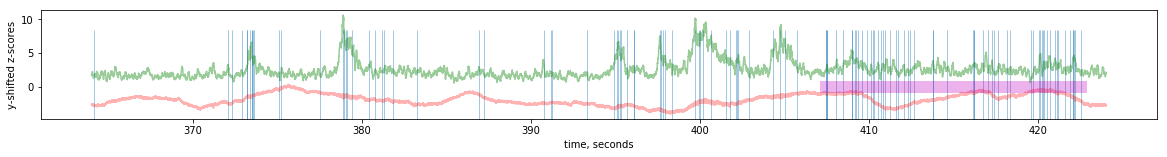

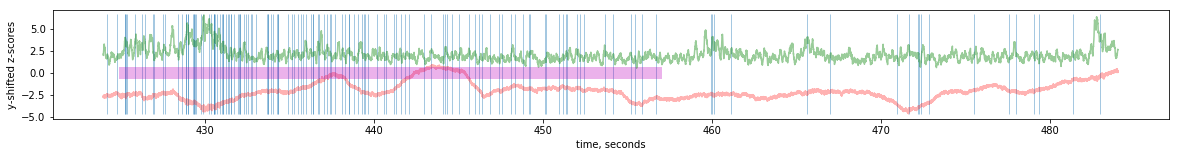

In [179]:
trial_n=27; t_begin = 364*4000; t_end = 493*4000 #len(trials['EMGs'][trial_n]); 
t_period = 60*4000;

while t_begin < t_end-t_period:
    # plot features
    tr_name = file_names_3ch[trial_n]
    mice_n = tr_name[0:2] 
    rec_time = tr_name[3:5] + ':' + tr_name[5:7] + ':' + tr_name[7:9]
    # plt.title('Mice number=' + mice_n + ', time: ' + rec_time + ', trial_n=' + str(trial_n))
    fig = plt.gcf();  fig.set_size_inches(20,2); 
    
    # timing
    time_range = list(range(t_begin,t_begin + t_period))
    time_range=np.multiply(1/4000,time_range)
    # plot spikes
    spks_times_plt = [t for t in trials['spike times'][trial_n] \
                      if (t  > t_begin and t < t_begin + t_period)]
    spks_times_plt = np.multiply(1/4000,spks_times_plt)
    spk_tics_plt=[1]*len(spks_times_plt)
    plt.plot(spks_times_plt, spk_tics_plt, linestyle='', \
             marker='|', alpha=.4, markersize=100)
    # plot EMG
    emg_z = sp.stats.zscore(trials['EMGs'][trial_n])
    plt.plot(time_range,emg_z[t_begin:t_begin+t_period]-2,'r-',alpha=.3)
    
    # plot segments
    for stt in amw:
        if stt[0]>t_begin and stt[1]<t_begin+t_period:
            stt[0]=stt[0]
            stt[1] = stt[1]
            stt=np.multiply(stt,1/4000)
            
            plt.plot(stt,[0, 0],'m-',alpha=.3,linewidth=12)
            
    
#     # plot segments
#     for stt in aaw:
#         if stt[0]>t_begin:
#             stt=np.multiply(stt,1/4000)
#             plt.plot(stt,[0, 0],'m-',alpha=.3,linewidth=9)
            # ???.fill_between(stt, [-1,-1], [1,1], facecolor='yellow', alpha=.3, interpolate=True)
    # plot segments
#     for stt in bursts:
#         if stt[0]>t_begin and stt[1]<t_begin+t_period:
#             stt=np.multiply(stt,1/4000)
#             plt.plot(stt,[0, 0],'m-',alpha=.3,linewidth=12)
    
    # plot muscle activity
    musc_z = sp.stats.zscore(trials['movement'][trial_n])
    plt.plot(time_range,musc_z[t_begin: t_begin+t_period]+2,'g',alpha=.4)
    
    plt.xlabel('time, seconds')
    plt.ylabel('y-shifted z-scores')
    
    plt.show()
    t_begin = t_begin+t_period

# FANO

In [273]:
## fano 
start = timer()
tr_n=25

periods=list(range(400,32000,400))
spk_Ns=[];
spk_ts = trials['spike times'][tr_n]
for period in periods:
    spk_N=[]
    for i in range(0,len(trials['spike bin'][tr_n])-period, int(period/6)):
        sp=0
        for j in spk_ts:
            if j>i and j < i+period:
                sp+=1
            else:
                break
        # sp=sp/(period/4000)
        spk_N.append(sp)
    spk_Ns.append(spk_N)
    
end = timer()
print(end - start)

0.13552722102031112


In [229]:
## fano some trials and period
def fano_adv_p(tr_n,period,start,end):
    spk_ts = trials['spike times'][tr_n]
    spk_N=[]
    for i in range(start,end-period, int(period/6)):
        sp=0
        for j in spk_ts:
            if j>i and j < i+period:
                sp=sp+1
        spk_N.append(sp)
    return np.var(spk_N)/np.mean(spk_N)

In [282]:
trials['fano, 1s']= [fano_adv(tr_n, 4000) for tr_n in range(len(trials))]

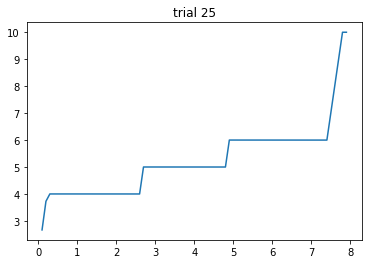

In [274]:
fanos=[]
for i in spk_Ns:
    fanos.append(fano(i))
periods=np.multiply(periods,1/4000)
plt.plot(periods,fanos)
plt.title('trial ' + str(tr_n))
plt.show()
# fanos

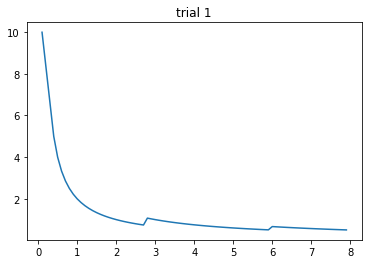

In [268]:
fanos=[]
for i in spk_Ns:
    fanos.append(fano(i))
periods=np.multiply(periods,1/4000)
plt.plot(periods,fanos)
plt.title('trial ' + str(tr_n))
plt.show()
# fanos

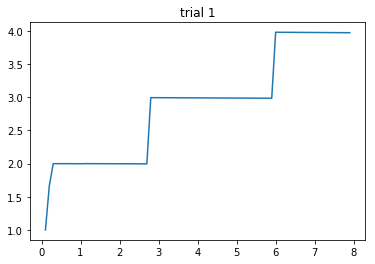

In [272]:
fanos=[]
for i in spk_Ns:
    fanos.append(fano(i))
periods=np.multiply(periods,1/4000)
plt.plot(periods,fanos)
plt.title('trial ' + str(tr_n))
plt.show()
# fanos

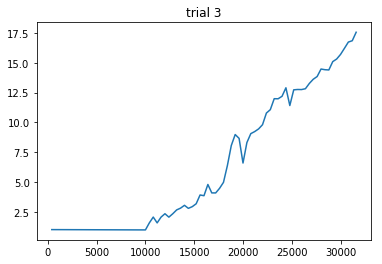

In [245]:
fanos=[]
for i in spk_Ns:
    fanos.append(fano(i))
plt.plot(periods,fanos)
plt.title('trial ' + str(tr_n))
plt.show()
# fanos

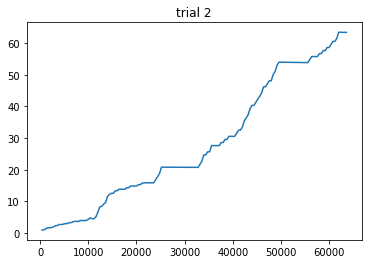

In [247]:
fanos=[]
for i in spk_Ns:
    fanos.append(fano(i))
plt.plot(periods,fanos)
plt.title('trial ' + str(tr_n))
plt.show()
# fanos

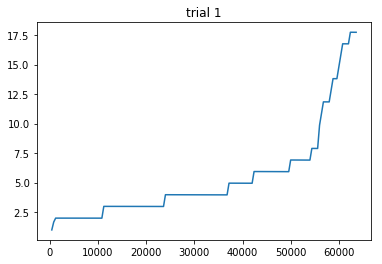

In [265]:
fanos=[]
for i in spk_Ns:
    fanos.append(fano(i))
plt.plot(periods,fanos)
plt.title('trial ' + str(tr_n))
plt.show()
# fanos

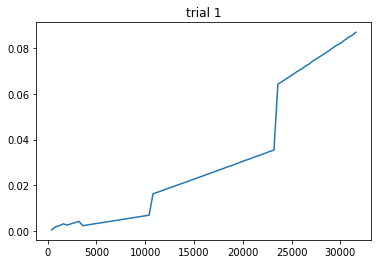

In [254]:
varis=[]
for i in spk_Ns:
    varis.append(np.var(i))
plt.plot(periods,varis)
plt.title('trial ' + str(tr_n))
plt.show()

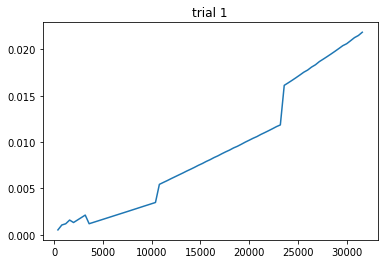

In [255]:
ms=[]
for i in spk_Ns:
    ms.append(np.mean(i))
plt.plot(periods,ms)
plt.title('trial ' + str(tr_n))
plt.show()

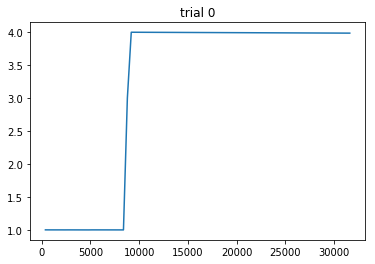

In [239]:
fanos=[]
for i in spk_Ns:
    fanos.append(fano(i))
plt.plot(periods,fanos)
plt.title('trial ' + str(tr_n))
plt.show()
# fanos

In [ ]:
def fano_seg(sp_ts,T):
    # sp_ts is vector with times of spikes
    # T is the time scale for partitions
    
    varX = np.var(x); meanX = np.mean(x);
    return varX/meanX
fano(spk_N)

### Plot the data

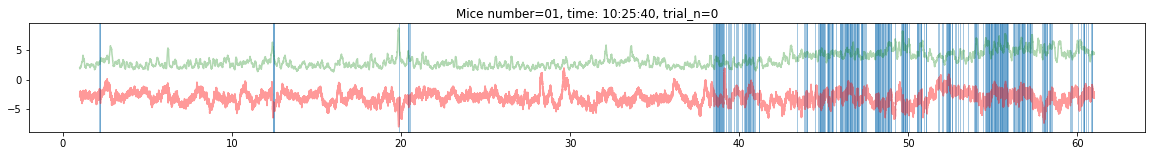

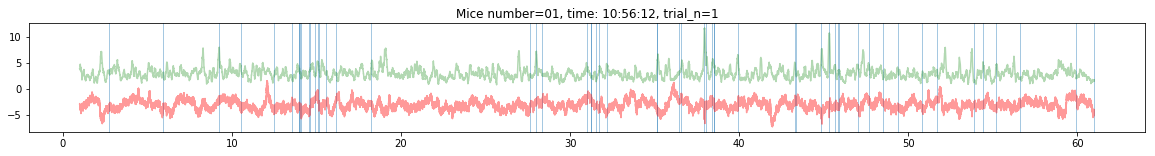

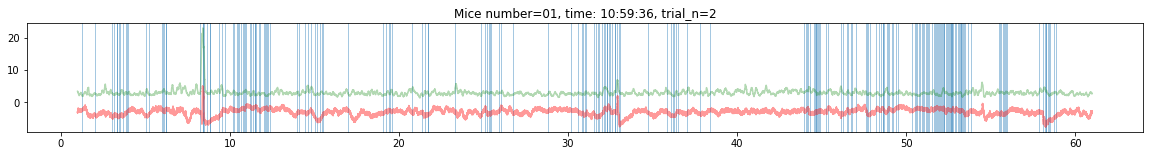

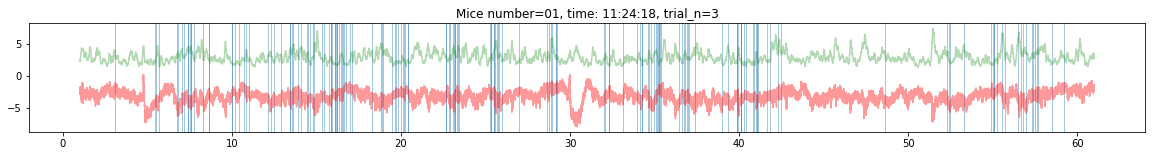

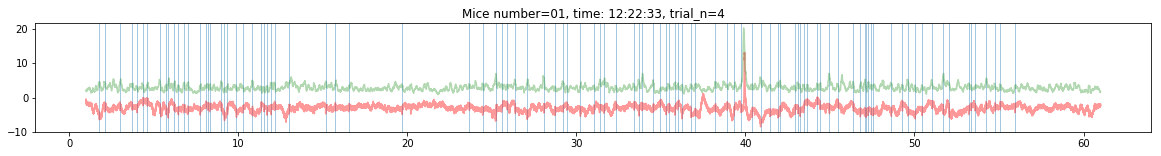

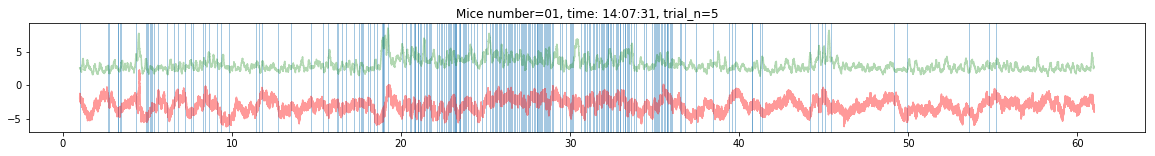

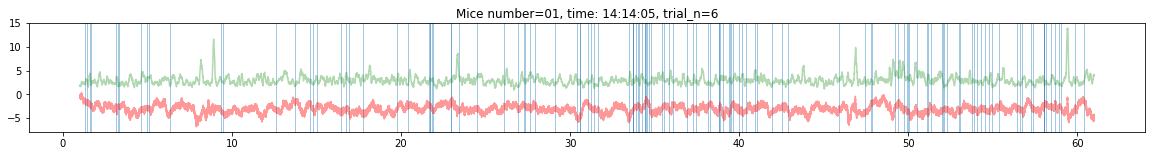

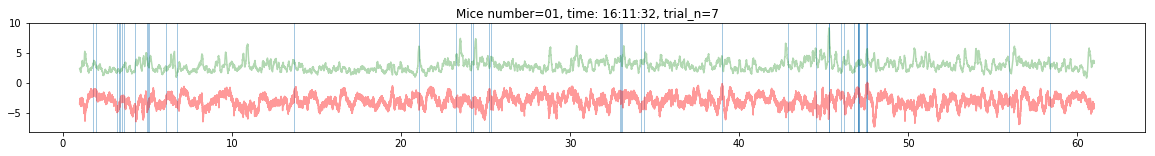

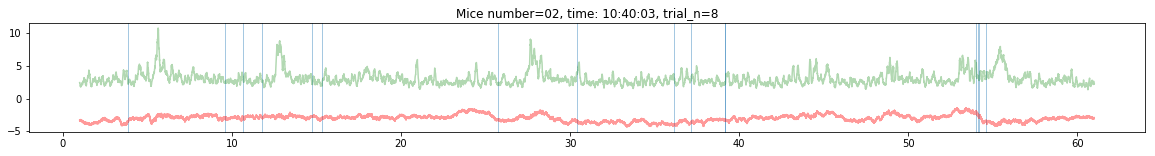

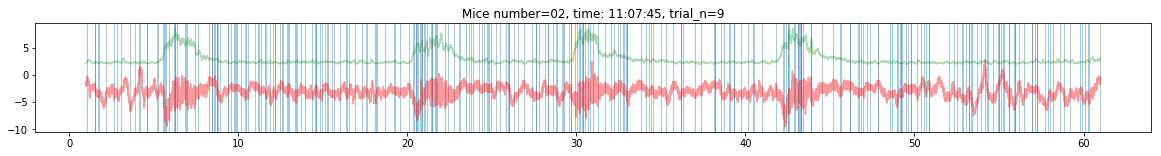

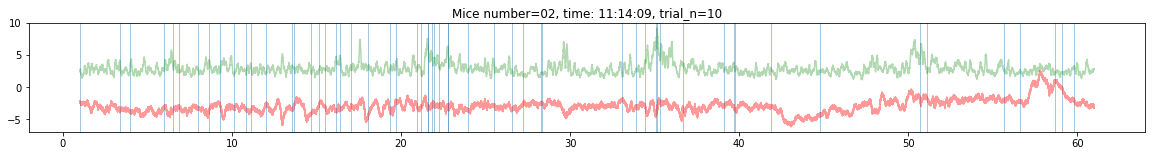

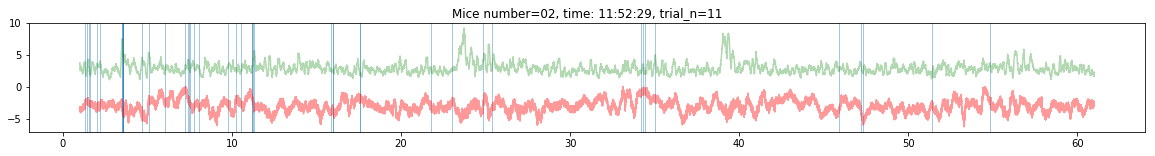

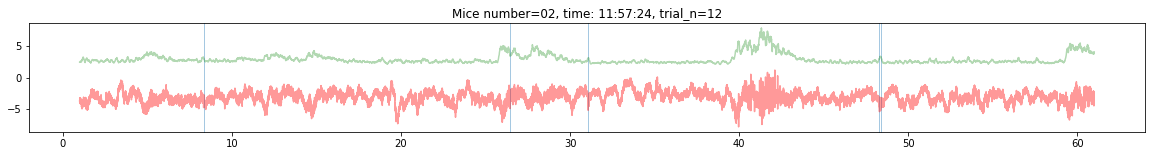

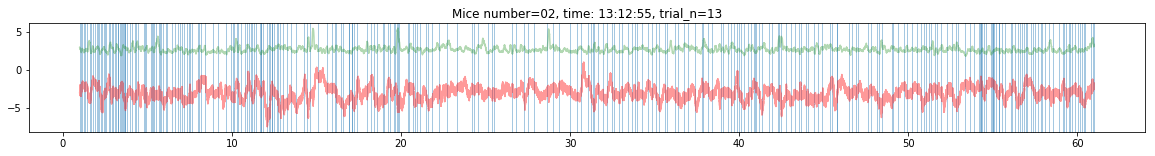

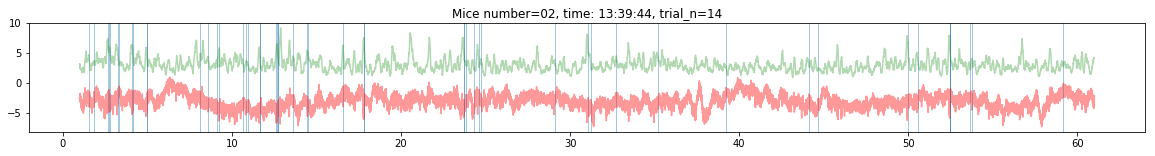

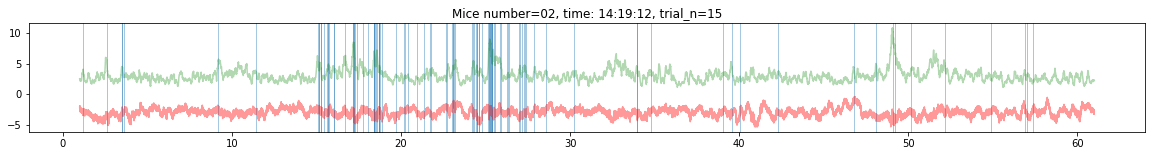

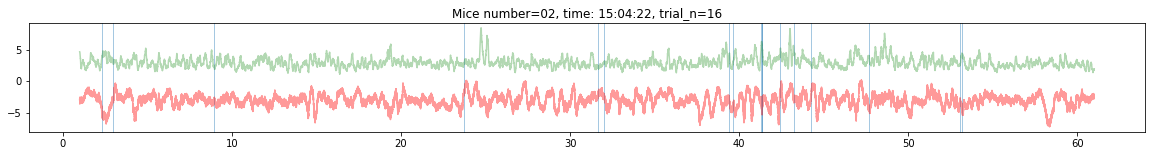

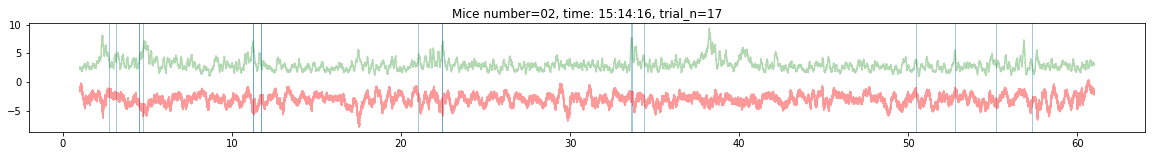

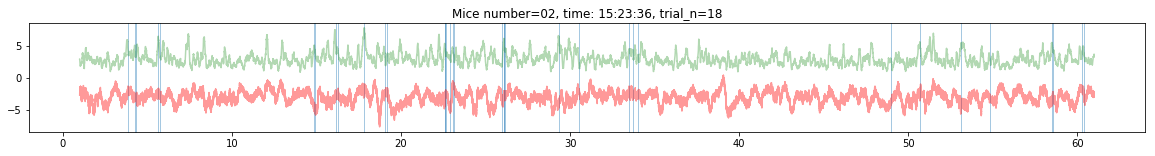

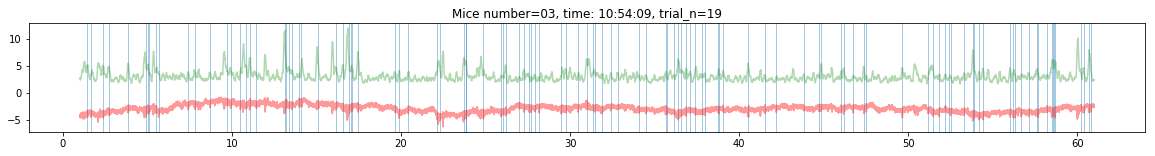

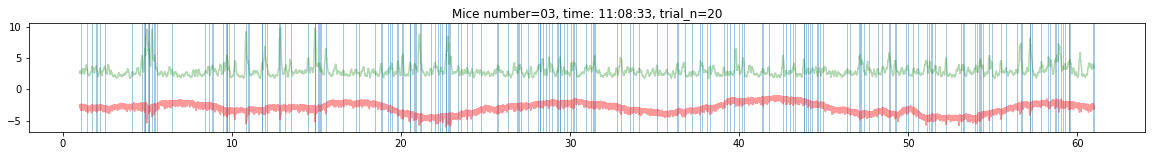

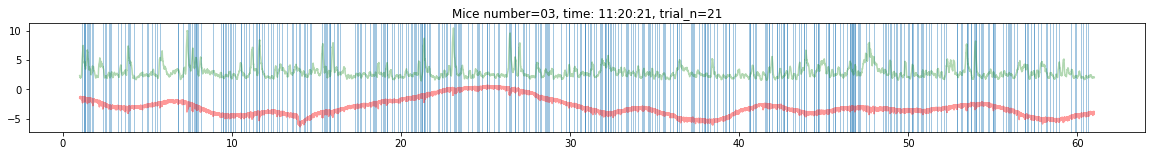

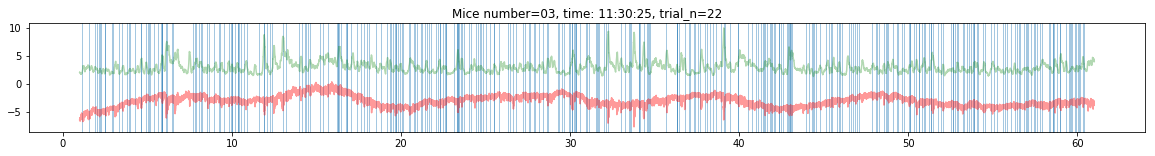

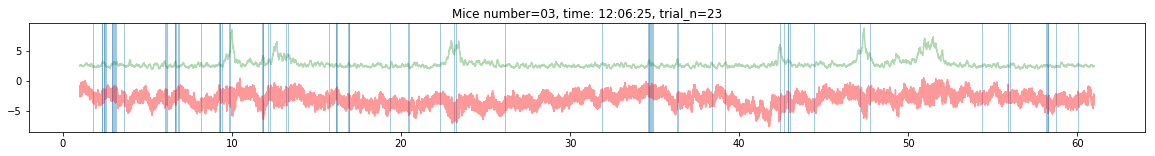

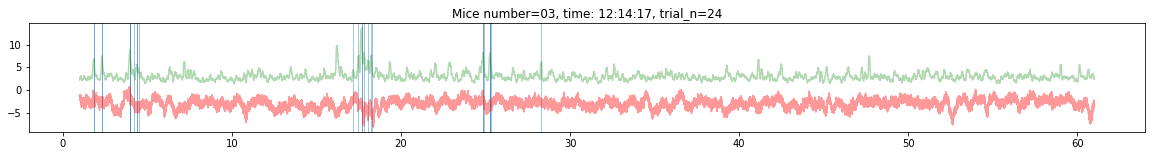

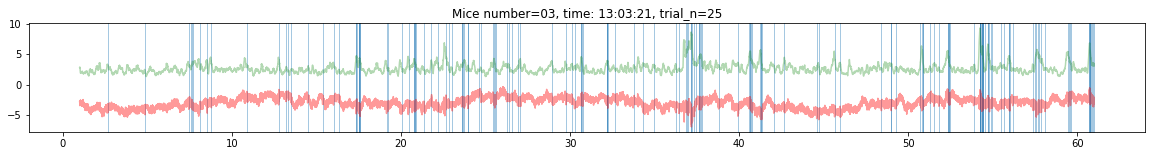

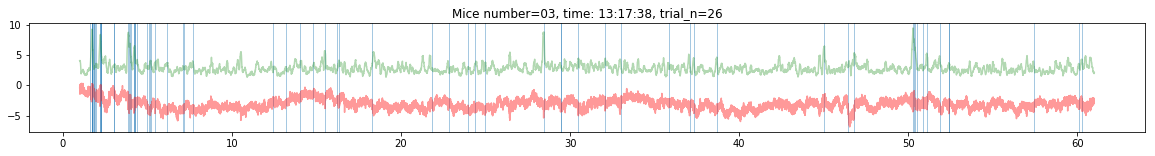

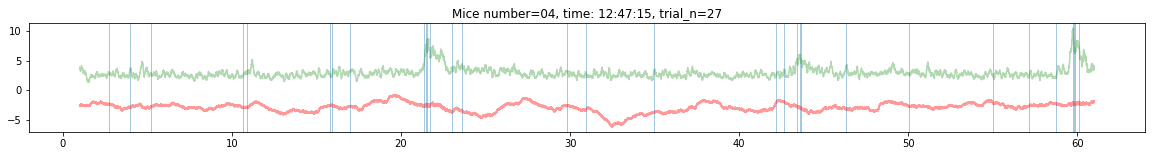

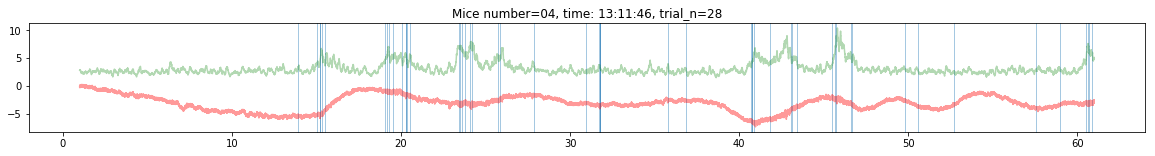

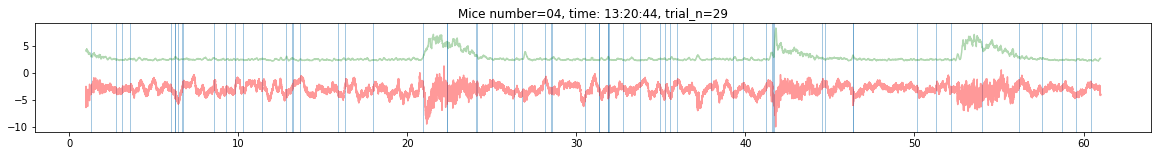

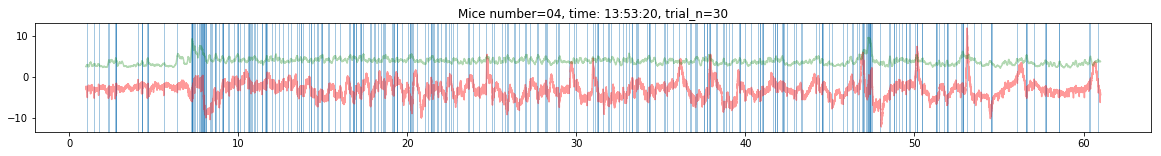

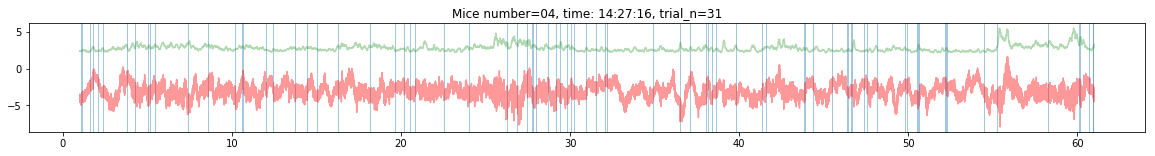

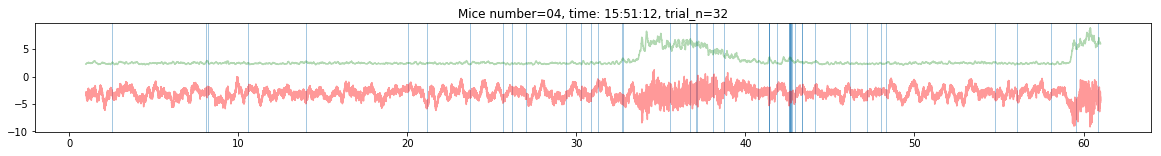

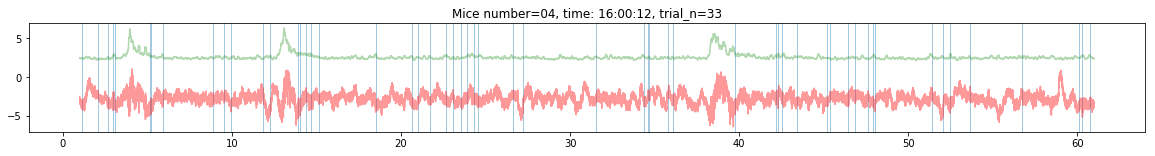

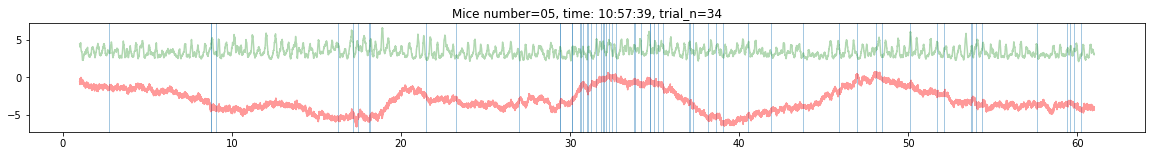

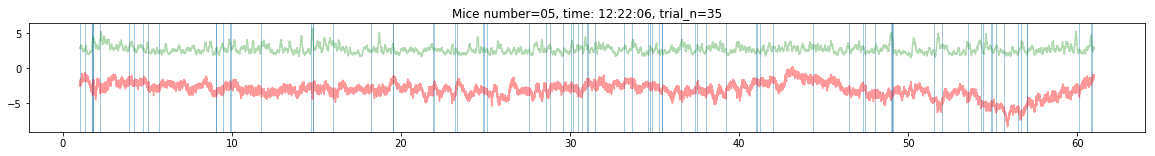

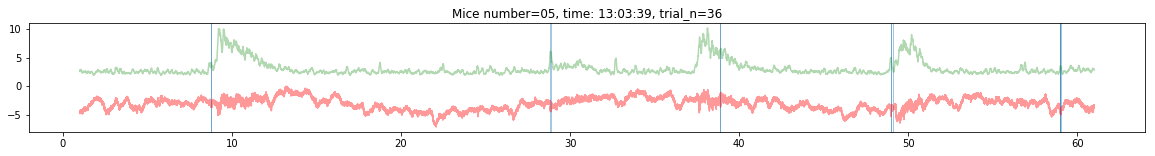

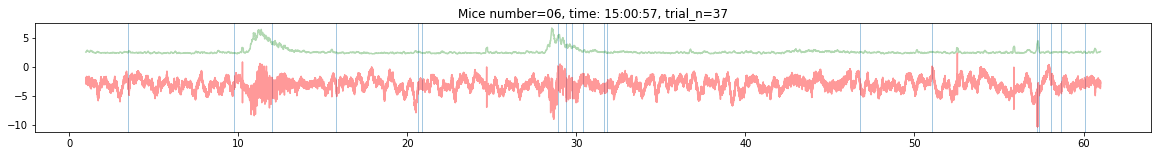

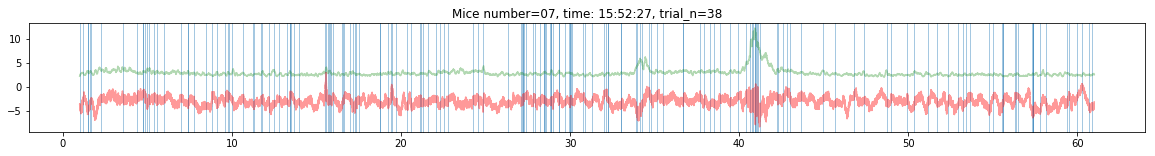

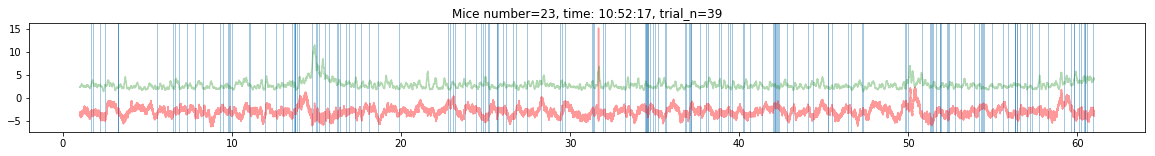

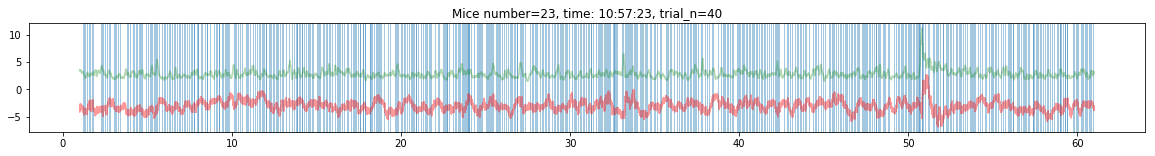

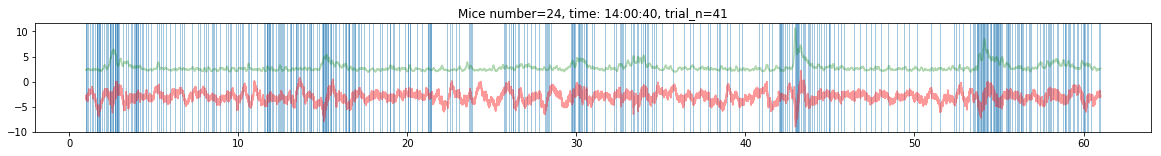

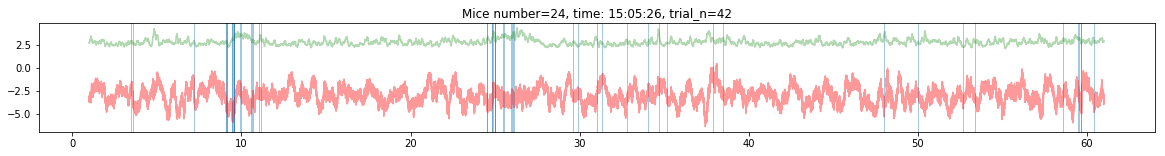

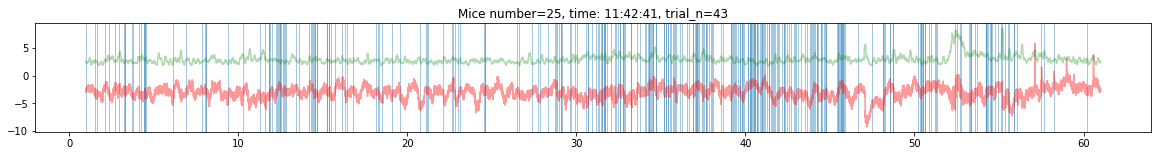

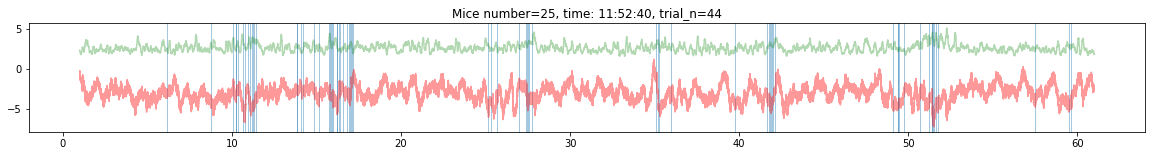

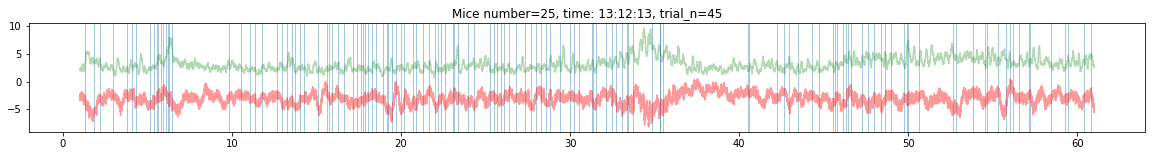

In [830]:
t_plt_begin = 4000; t_plt_period = 240000;
for trial_n in range(46):
    # timing
    t_plt_end=t_plt_begin+t_plt_period
    time_range = list(range(t_plt_begin,t_plt_end))
    time_range = np.multiply(1/4000,time_range)
    # plot spikes
    trials['spike times'].loc[trial_n][()]
    spks_times_plt = [t for t in spike_times[trial_n] \
                      if (t  > t_plt_begin and t < t_plt_end)]
    spks_times_plt = np.multiply(1/4000,spks_times_plt)
    spk_tics_plt=[1]*len(spks_times_plt)
    plt.plot(spks_times_plt, spk_tics_plt, linestyle='', \
             marker='|', alpha=.4, markersize=200)

    # plot EMG
    emg_z = sp.stats.zscore(emgs[trial_n])
    plt.plot(time_range,emg_z[t_plt_begin:t_plt_end]-3,'r-',alpha=.4)
    
    # plot muscle activity
    musc_z = sp.stats.zscore(musc[trial_n])
    plt.plot(time_range,musc_z[t_plt_begin:t_plt_end]+3,'g',alpha=.3)
    
    # plot features
    tr_name = file_names_3ch[trial_n]
    mice_n = tr_name[0:2] 
    rec_time = tr_name[3:5] + ':' + tr_name[5:7] + ':' + tr_name[7:9]
    plt.title('Mice number=' + mice_n + ', time: ' + rec_time + ', trial_n=' + str(trial_n))
    fig = plt.gcf()
    fig.set_size_inches(20,2)
    plt.show() 
    # [0.33, 0.51, 6.24 , 0.53, 0.97, 1.72, 0.48 , 0.93, 5.17])

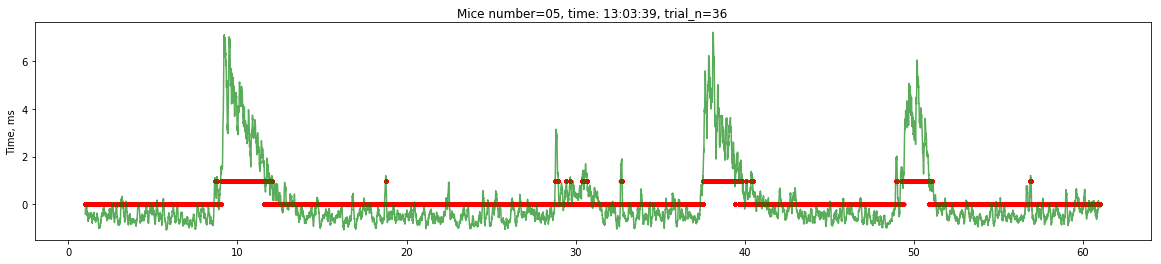

In [888]:
t_plt_begin = 4000; t_plt_period = 240000;


for trial_n in [36]:
    # timing
    t_plt_end=t_plt_begin+t_plt_period
    time_range = list(range(t_plt_begin,t_plt_end))
    time_range=np.multiply(1/4000,time_range)
    
    msc_high = [msc>1 for msc in musc_z]
    plt.plot(time_range,msc_high[t_plt_begin:t_plt_end],'ro',alpha=.9, markersize=3)
    
    # plot muscle activity
    musc_z = sp.stats.zscore(musc[trial_n])
    plt.plot(time_range,musc_z[t_plt_begin:t_plt_end],'g',alpha=.65)

           
    # plot features
    tr_name = file_names_3ch[trial_n]
    mice_n = tr_name[0:2] 
    rec_time = tr_name[3:5] + ':' + tr_name[5:7] + ':' + tr_name[7:9]
    plt.title('Mice number=' + mice_n + ', time: ' + rec_time + ', trial_n=' + str(trial_n))
    fig = plt.gcf()
    fig.set_size_inches(20,4)
    plt.ylabel('Time, ms')
    plt.show() 
    # [0.33, 0.51,

#### Create helping spike arrays

In [800]:
# create binary spike timing array
spikes_bin = [0]*len(trials)
for trial_n in range(len(trials)):
    spike_times[trial_n] = [ int(t) for t in spike_times[trial_n] ] 
    spikes_bin[trial_n] = np.zeros(len(emgs[trial_n]))
    spikes_bin[trial_n][spike_times[trial_n]]=1

In [801]:
# Interspike interval
isi=[0]*len(trials)
for trial_n in range(len(trials)):
    isi[trial_n] = [int(spike_times[trial_n][n+1] - spike_times[trial_n][n]) \
                    for n in range( len(spike_times[trial_n]) -1 ) ]    

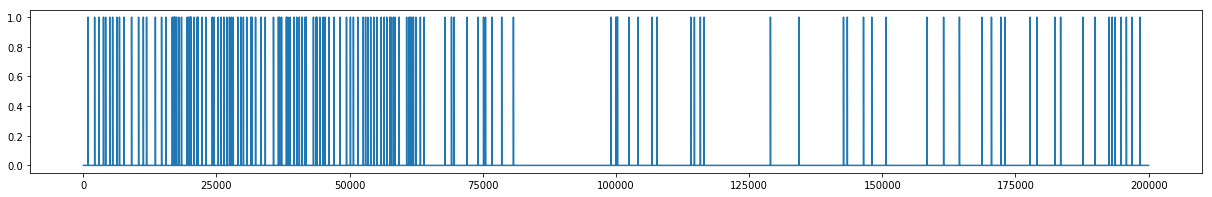

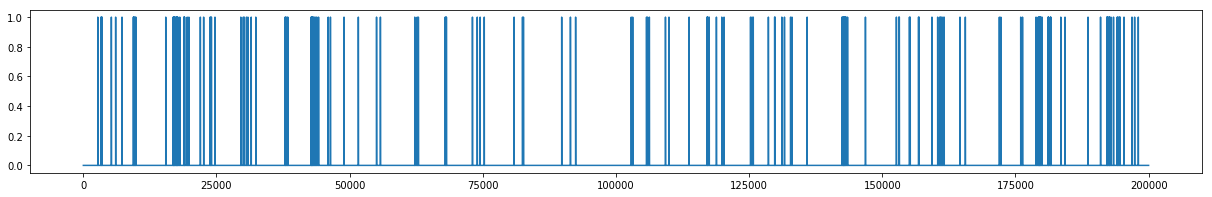

0.8394202080578604
0.6674410828578557


In [774]:
plt.plot(spikes_bin[0][200000:400000])
# plot properties and show
fig = plt.gcf()
fig.set_size_inches(21,3)
plt.show()

plt.plot(spikes_bin[1][200000:400000])
# plot properties and show
fig = plt.gcf()
fig.set_size_inches(21,3)
plt.show()

t0 = 200000; t1= 400000;
isi0sec = [isi[0][k]/4000 for k in range(len(spike_times[0])) \
        if (spike_times[0][k]>t0 and spike_times[0][k]<t1)]
isi1sec = [isi[1][k]/4000 for k in range(len(spike_times[1])) \
        if (spike_times[1][k]>t0 and spike_times[1][k]<t1)]


def fano(x):
    # x is the vector with ISI
    varX = np.var(x); meanX = np.mean(x);
    return varX/meanX

print(fano(isi0sec))
print(fano(isi1sec))

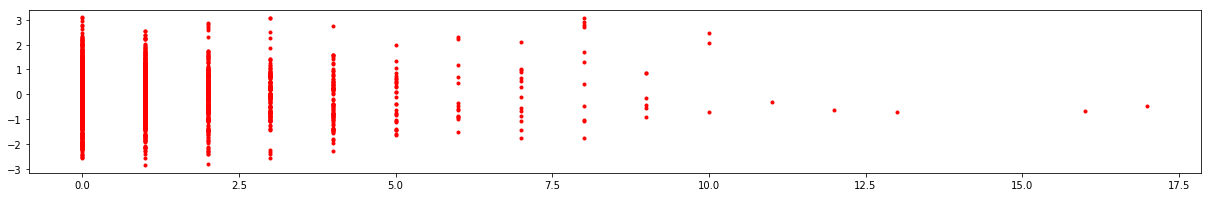

In [816]:
# create spike rate array
t_window = 6000;
trial_n = 34
spikes_freq = []; musc_level = []; emg_level = [];
for t in range(0,len(spikes_bin[trial_n])-t_window,2000):
    spikes_freq.append(sum(spikes_bin[trial_n][t:t+t_window]))
    musc_level.append(np.mean(musc[trial_n][t:t+t_window]))
    emg_level.append(np.mean(emgs[trial_n][t:t+t_window]))
plt.plot(spikes_freq,emg_level,'r.')
# plt.plot(sp.stats.zscore(musc_level),'r')
fig = plt.gcf()
fig.set_size_inches(21,3)
plt.show()

### Cluster

In [891]:
# trial_props = [ [freqs[n], entropies[n], fanos[n]] for n in range(len(emgs))]
trial_props = [ [ freqs[n], cors_musc[n] ] for n in range(len(emgs))]
kmeans = KMeans(n_clusters=2, random_state=0).fit(trial_props)
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 0])

In [892]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=3, min_samples=2).fit(trial_props)
clustering.labels_

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0], dtype=int64)